# AI Engineering Drawing Inspector v3.0

**Multi-Model QC Pipeline with Drawing Classification**

**Architecture:**
- LightOnOCR-2-1B: Text/dimension extraction
- Qwen2.5-VL-7B: Visual understanding (4 analyses)
- GPT-4o-mini: Report generation

**Outputs:**
1. `ResolvedPartIdentity.json`
2. `QwenUnderstanding.json` (features, quality, BOM, mfg notes)
3. `DrawingEvidence.json`
4. `DiffResult.json`
5. `QCReport.md`

**v3.0 Implemented Features:**
- Multi-page PDF rendering (all pages processed)
- Proper variable initialization (fixes stale data issue)
- Assembly/BOM drawing support (no SW comparison needed)
- Qwen data used for reports when SW data unavailable

**v3.1 Roadmap:**
- Drawing classification before OCR (ASSEMBLY_BOM vs PART_DETAIL)
- Conditional OCR (skip for BOM pages)
- GD&T symbol detection

In [1]:
# @title Run in Colab
# [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/skaumbdoallsaws-coder/AI-Drawing-Inspector/blob/main/ai_inspector_v3.ipynb)

# Cell 1: Install Dependencies
!pip install -q pymupdf opencv-python-headless jsonschema pillow pytesseract
!pip install -q accelerate qwen-vl-utils bitsandbytes
!pip install -q git+https://github.com/huggingface/transformers
!pip install -q json-repair openai
!apt-get install -y poppler-utils tesseract-ocr > /dev/null 2>&1
print("Dependencies installed!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 65.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 10.8 MB/s eta 0:00:00
Dependencies installed!


In [2]:
# Cell 2: Imports and Configuration
import os, json, re, gc
import torch
import fitz
import numpy as np
from PIL import Image
from pathlib import Path
from dataclasses import dataclass, field, asdict
from typing import List, Dict, Any, Optional, Tuple
from datetime import datetime

# Configuration
DRAWING_PDF_PATH = ""
SOLIDWORKS_JSON_DIR = "sw_json_library"
OUTPUT_DIR = "qc_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

PyTorch: 2.9.0+cu126
CUDA: True


In [3]:
# Cell 3: BOM-Robust JSON Loader
def load_json_robust(filepath) -> Tuple[Optional[Dict], Optional[str]]:
    """Load JSON with BOM handling. Tries: utf-8-sig, utf-8, latin-1"""
    filepath = Path(filepath)
    for enc in ['utf-8-sig', 'utf-8', 'latin-1']:
        try:
            with open(filepath, 'r', encoding=enc) as f:
                return json.load(f), None
        except UnicodeDecodeError:
            continue
        except json.JSONDecodeError as e:
            if 'BOM' in str(e) and enc == 'utf-8':
                continue
            return None, f"JSON error: {str(e)[:50]}"
        except Exception as e:
            return None, f"Error: {str(e)[:50]}"
    return None, "Failed all encodings"

print("load_json_robust defined")

load_json_robust defined


In [4]:
# Cell 4: PDF Rendering (Multi-Page Support)
@dataclass
class PageArtifact:
    pageIndex0: int
    page: int
    image: Image.Image
    width: int
    height: int
    dpi: int
    direct_text: Optional[str] = None
    # v3: Classification fields (populated later)
    drawing_type: Optional[str] = None  # ASSEMBLY_BOM, PART_DETAIL, MIXED
    needs_ocr: bool = True
    has_bom: bool = False

def render_pdf(pdf_path: str, dpi: int = 300) -> List[PageArtifact]:
    """Render ALL pages of PDF to images (v3 multi-page support)."""
    artifacts = []
    doc = fitz.open(pdf_path)
    total_pages = len(doc)
    print(f"PDF has {total_pages} page(s)")

    for page_idx in range(total_pages):
        page = doc.load_page(page_idx)
        zoom = dpi / 72.0
        pix = page.get_pixmap(matrix=fitz.Matrix(zoom, zoom), alpha=False)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        direct_text = page.get_text("text")

        artifacts.append(PageArtifact(
            pageIndex0=page_idx,
            page=page_idx + 1,
            image=img,
            width=pix.width,
            height=pix.height,
            dpi=dpi,
            direct_text=direct_text if len(direct_text.strip()) > 10 else None
        ))
        print(f"  Page {page_idx + 1}: {pix.width}x{pix.height}px")

    doc.close()
    return artifacts

print("render_pdf defined (multi-page support)")

render_pdf defined (multi-page support)


In [5]:
# Cell 5: SolidWorks JSON Library
@dataclass
class SwPartEntry:
    json_path: str
    part_number: str
    filename_stem: str = ""
    data: Dict[str, Any] = field(default_factory=dict)

class SwJsonLibrary:
    def __init__(self):
        self.by_part_number: Dict[str, SwPartEntry] = {}
        self.by_filename: Dict[str, SwPartEntry] = {}
        self.all_entries: List[SwPartEntry] = []

    def _normalize(self, s: str) -> str:
        return re.sub(r'[-\s_]', '', str(s or '')).lower()

    def load_from_directory(self, directory: str):
        json_files = list(Path(directory).glob("**/*.json"))
        print(f"Found {len(json_files)} JSON files")

        for jp in json_files:
            data, err = load_json_robust(jp)
            if data is None:
                continue
            pn = data.get('identity', {}).get('partNumber', '')
            entry = SwPartEntry(str(jp), pn, jp.stem, data)
            self.all_entries.append(entry)
            if pn:
                self.by_part_number[pn] = entry
                self.by_part_number[self._normalize(pn)] = entry
            self.by_filename[jp.stem] = entry
            self.by_filename[self._normalize(jp.stem)] = entry
        print(f"Loaded {len(self.all_entries)} files")

    def lookup(self, candidate: str) -> Optional[SwPartEntry]:
        if not candidate:
            return None
        norm = self._normalize(candidate)
        return self.by_part_number.get(candidate) or self.by_part_number.get(norm) or \
               self.by_filename.get(candidate) or self.by_filename.get(norm)

sw_library = SwJsonLibrary()
print("SwJsonLibrary defined")

SwJsonLibrary defined


In [6]:
# Cell 6: Part Identity Resolution (Robust Matching)

@dataclass
class ResolvedPartIdentity:
    partNumber: str
    confidence: float
    source: str
    swJsonPath: Optional[str] = None
    candidates_tried: List[str] = field(default_factory=list)

def clean_filename(filename: str) -> str:
    """Remove known suffixes like Paint, REV, etc."""
    cleaned = re.sub(r'[\s_]*(Paint|PAINT)$', '', filename, flags=re.IGNORECASE)
    return cleaned.strip()

def extract_pn_candidates(filename: str) -> List[str]:
    """
    Extract potential part number candidates from filename.
    Handles: 1013572_01, 101357201-03, 314884W_0, 046-935-REV-A
    Returns list of candidates (most specific to least).
    """
    name_no_ext = os.path.splitext(filename)[0]
    # Remove duplicate markers like (1), (2)
    name_no_ext = re.sub(r'\s*\(\d+\)$', '', name_no_ext)
    cleaned = clean_filename(name_no_ext)
    parts = re.split(r'[\s_]+', cleaned)

    if not parts:
        return []

    base = parts[0]
    candidates = []

    # 1. Base as-is
    candidates.append(base)

    # 2. Without hyphens
    base_no_hyphen = base.replace('-', '')
    if base_no_hyphen != base:
        candidates.append(base_no_hyphen)

    # 3. Remove letter suffixes (046-935A -> 046-935)
    if base and base[-1].isalpha() and len(base) > 1:
        candidates.append(base[:-1])
        candidates.append(base[:-1].replace('-', ''))

    # 4. Handle revision pattern (046-935-01 -> 046-935)
    rev_match = re.match(r'^(.+)-(\d{1,2})$', base)
    if rev_match:
        main_part = rev_match.group(1)
        candidates.append(main_part)
        candidates.append(main_part.replace('-', ''))

    # 5. Handle REV suffix (046-935-REV-A -> 046-935)
    rev_alpha = re.match(r'^(.+?)[-_]?REV[-_]?[A-Z0-9]*$', base, re.IGNORECASE)
    if rev_alpha:
        candidates.append(rev_alpha.group(1))
        candidates.append(rev_alpha.group(1).replace('-', ''))

    # 6. Peeling - progressively remove trailing digits
    temp = base_no_hyphen
    while len(temp) > 5:
        temp = temp[:-1]
        candidates.append(temp)

    # Remove duplicates, preserve order
    seen = set()
    unique = []
    for c in candidates:
        if c and c not in seen:
            seen.add(c)
            unique.append(c)

    return unique

def resolve_part_identity(pdf_path: str, artifacts: List[PageArtifact], sw_lib: SwJsonLibrary) -> ResolvedPartIdentity:
    """Resolve part identity using robust filename matching."""
    filename = os.path.basename(pdf_path)
    candidates = extract_pn_candidates(filename)

    # Try each candidate against SW library
    for candidate in candidates:
        entry = sw_lib.lookup(candidate)
        if entry:
            return ResolvedPartIdentity(
                partNumber=entry.part_number or candidate,
                confidence=1.0,
                source="filename+sw",
                swJsonPath=entry.json_path,
                candidates_tried=candidates
            )

    # Try PDF embedded text
    for art in artifacts:
        if art.direct_text:
            text_candidates = extract_pn_candidates(art.direct_text[:200])
            for candidate in text_candidates[:5]:
                entry = sw_lib.lookup(candidate)
                if entry:
                    return ResolvedPartIdentity(
                        partNumber=entry.part_number or candidate,
                        confidence=0.8,
                        source="pdf_text+sw",
                        swJsonPath=entry.json_path,
                        candidates_tried=candidates + text_candidates[:5]
                    )

    # Fallback - use first candidate or filename stem
    fallback_pn = candidates[0] if candidates else Path(pdf_path).stem
    return ResolvedPartIdentity(
        partNumber=fallback_pn,
        confidence=0.3,
        source="fallback",
        swJsonPath=None,
        candidates_tried=candidates
    )

print("resolve_part_identity defined (robust matching)")

resolve_part_identity defined (robust matching)


In [7]:
# Cell 7: Load SolidWorks Library (Upload ZIP)
from google.colab import files
import zipfile

if not os.path.exists(SOLIDWORKS_JSON_DIR) or not list(Path(SOLIDWORKS_JSON_DIR).glob("*.json")):
    print("Upload your sw_json_library.zip file:")
    uploaded = files.upload()

    for filename in uploaded:
        if filename.endswith('.zip'):
            print(f"Extracting {filename}...")
            with zipfile.ZipFile(filename, 'r') as z:
                z.extractall(SOLIDWORKS_JSON_DIR)
            print(f"Extracted to {SOLIDWORKS_JSON_DIR}")
            break

sw_library.load_from_directory(SOLIDWORKS_JSON_DIR)
print(f"Library ready: {len(sw_library.all_entries)} parts indexed")

# === Load Mating & Sibling Context Databases ===
part_context_db = {}
inspector_requirements_db = {}

def _try_load_json(name, search_paths):
    """Try loading a JSON file from multiple paths."""
    for p in search_paths:
        full = os.path.join(p, name)
        if os.path.exists(full):
            with open(full, 'r', encoding='utf-8') as f:
                data = json.load(f)
            print(f"  Loaded {name}: {len(data)} entries from {p}")
            return data
    return None

# Search paths: extracted ZIP dir first, then known project paths
_search_paths = [
    SOLIDWORKS_JSON_DIR,
    os.path.join(SOLIDWORKS_JSON_DIR, '..'),
    '/content',
]

print("\nLoading assembly context databases...")
part_context_db = _try_load_json('sw_part_context_complete.json', _search_paths) or {}
inspector_requirements_db = _try_load_json('sw_inspector_requirements.json', _search_paths) or {}

if not part_context_db:
    print("  sw_part_context_complete.json not found.")
    print("  Upload it alongside your ZIP, or add it to the ZIP.")
    print("  Sibling/mating context will not be available.")

if not inspector_requirements_db:
    print("  sw_inspector_requirements.json not found.")
    print("  Mate-derived thread requirements will not be available.")

def get_part_context(part_number: str) -> Dict:
    """Look up part in context DB by new_pn, old_pn, or normalized variants."""
    if not part_context_db:
        return None
    candidates = [
        part_number,
        part_number.upper(),
        part_number.lower(),
        part_number.replace('-', ''),
        part_number.replace('_', ''),
        part_number.replace('-', '').lower(),
    ]
    for key in candidates:
        if key in part_context_db:
            return part_context_db[key]
    # Also search by new_pn field inside entries
    for key, entry in part_context_db.items():
        identity = entry.get('identity', {})
        if identity.get('new_pn') == part_number or identity.get('old_pn') == part_number:
            return entry
    return None

def get_inspector_requirements(part_number: str) -> Dict:
    """Look up inspector requirements by part number.
    Uses part_context_db to resolve new_pn -> old_pn mapping."""
    if not inspector_requirements_db:
        return None

    # Direct lookup by various formats
    candidates = [
        part_number,
        part_number.upper(),
        part_number.lower(),
        part_number.replace('-', ''),
        part_number.replace('-', '').lower(),
    ]
    for key in candidates:
        if key in inspector_requirements_db:
            return inspector_requirements_db[key]

    # Use part_context_db to find old_pn, then lookup by that
    ctx = get_part_context(part_number)
    if ctx:
        old_pn = ctx.get('identity', {}).get('old_pn', '')
        if old_pn:
            old_candidates = [old_pn, old_pn.replace('-', ''), old_pn.upper(), old_pn.lower()]
            for key in old_candidates:
                if key in inspector_requirements_db:
                    return inspector_requirements_db[key]

    return None

print(f"\nAssembly context: {len(part_context_db)} parts")
print(f"Inspector requirements: {len(inspector_requirements_db)} entries")


Upload your sw_json_library.zip file:


Saving sw_json_library.zip to sw_json_library.zip
Extracting sw_json_library.zip...
Extracted to sw_json_library
Found 383 JSON files
Loaded 383 files
Library ready: 383 parts indexed

Loading assembly context databases...
  Loaded sw_part_context_complete.json: 597 entries from sw_json_library
  Loaded sw_inspector_requirements.json: 23 entries from sw_json_library

Assembly context: 597 parts
Inspector requirements: 23 entries


Upload your PDF drawing:


Saving 100881301_02.pdf to 100881301_02.pdf
Processing: 100881301_02.pdf
PDF has 1 page(s)
  Page 1: 3300x2550px


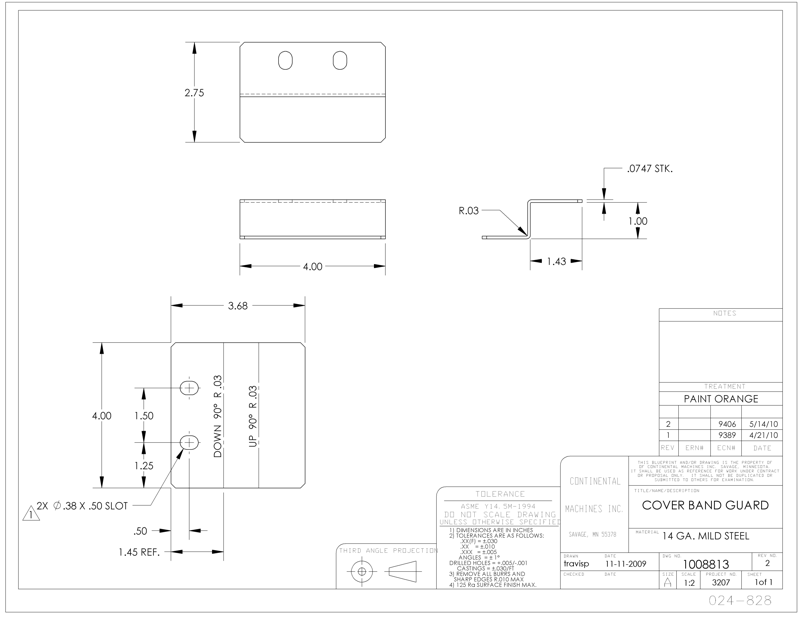

In [8]:
# Cell 8: Upload and Render PDF Drawing
from google.colab import files
from IPython.display import display

print("Upload your PDF drawing:")
uploaded = files.upload()

for filename in uploaded:
    if filename.lower().endswith('.pdf'):
        DRAWING_PDF_PATH = filename
        break

print(f"Processing: {DRAWING_PDF_PATH}")
artifacts = render_pdf(DRAWING_PDF_PATH)

# Display the rendered image
if artifacts:
    display(artifacts[0].image.resize((800, int(800 * artifacts[0].height / artifacts[0].width))))

In [9]:
# Cell 9: Resolve Part Identity
part_identity = resolve_part_identity(DRAWING_PDF_PATH, artifacts, sw_library)

print("="*50)
print("RESOLVED PART IDENTITY")
print("="*50)
print(f"Part Number:  {part_identity.partNumber}")
print(f"Confidence:   {part_identity.confidence}")
print(f"Source:       {part_identity.source}")
print(f"SW JSON:      {part_identity.swJsonPath or 'Not found'}")
print(f"Candidates:   {part_identity.candidates_tried[:5]}")

# === Assembly Context Lookup ===
assembly_context = None
mate_thread_reqs = []

ctx = get_part_context(part_identity.partNumber)
if ctx:
    assembly_context = ctx
    hierarchy = ctx.get('hierarchy', {})
    mating = ctx.get('mating', {})
    siblings = hierarchy.get('siblings', [])
    mates_with = mating.get('mates_with', [])
    mate_reqs_from_mates = mating.get('requirements_from_mates', [])

    # Count mate types
    thread_mates = [m for m in mates_with if m.get('thread') or 'THREAD' in str(m.get('mate_type', '')).upper()]
    concentric_mates = [m for m in mates_with if 'concentric' in str(m.get('mate_type', '')).lower()]

    print()
    print("="*50)
    print("ASSEMBLY CONTEXT")
    print("="*50)
    print(f"Parent Assembly: {hierarchy.get('parent_assembly', 'Unknown')}")
    print(f"Hierarchy Path:  {hierarchy.get('hierarchy_path', 'N/A')}")

    if siblings:
        print(f"\nSiblings ({len(siblings)} parts in same assembly):")
        for s in siblings[:8]:
            print(f"  - {s.get('pn', s.get('name', '?'))} ({s.get('desc', s.get('description', ''))})")
        if len(siblings) > 8:
            print(f"  ... and {len(siblings) - 8} more")

    if mates_with:
        print(f"\nMate Relationships ({len(mates_with)} total):")
        for m in mates_with[:6]:
            thread_info = f" [{m['thread']}x{m.get('pitch', '')}]" if m.get('thread') else ''
            print(f"  - {m.get('mate_type', 'MATE')}: {m.get('part', '?')} ({m.get('description', '')}){thread_info}")
        if len(mates_with) > 6:
            print(f"  ... and {len(mates_with) - 6} more")

    if mate_reqs_from_mates:
        print(f"\nMate-Derived Requirements ({len(mate_reqs_from_mates)}):")
        for req in mate_reqs_from_mates[:5]:
            print(f"  - {req}")
        if len(mate_reqs_from_mates) > 5:
            print(f"  ... and {len(mate_reqs_from_mates) - 5} more")
else:
    print("\nAssembly context: Not found in database")

# Also check inspector requirements
insp_reqs = get_inspector_requirements(part_identity.partNumber)
if insp_reqs:
    reqs_by_type = insp_reqs.get('requirements_by_type', {})
    thread_holes = reqs_by_type.get('thread_holes', [])
    if thread_holes:
        print(f"\nThread Hole Requirements from Mates ({len(thread_holes)}):")
        for th in thread_holes:
            print(f"  - {th}")
        mate_thread_reqs = thread_holes

# Save to output
identity_out = os.path.join(OUTPUT_DIR, "ResolvedPartIdentity.json")
with open(identity_out, 'w') as f:
    json.dump(asdict(part_identity), f, indent=2)
print(f"\nSaved: {identity_out}")

# Save assembly context
if assembly_context:
    ctx_out = os.path.join(OUTPUT_DIR, "AssemblyContext.json")
    with open(ctx_out, 'w') as f:
        json.dump({
            'partNumber': part_identity.partNumber,
            'hierarchy': assembly_context.get('hierarchy', {}),
            'mating': assembly_context.get('mating', {}),
            'identity': assembly_context.get('identity', {}),
        }, f, indent=2)
    print(f"Saved: {ctx_out}")


RESOLVED PART IDENTITY
Part Number:  1008813
Confidence:   1.0
Source:       filename+sw
SW JSON:      sw_json_library/1008813.json
Candidates:   ['100881301', '10088130', '1008813', '100881', '10088']

ASSEMBLY CONTEXT
Parent Assembly: ROOT
Hierarchy Path:  

Siblings (41 parts in same assembly):
  - 517499 (COUNTERBALANCE SPRINT ASSEM)
  - 326124 (BLOCK BEARING ASSY)
  - 199680 (SCR CAP HEX SCH M10X1.5X30)
  - 199680 (SCR CAP HEX SCH M10X1.5X30)
  - 046-908 (VISE AND PIVOT DETAIL)
  - 1009198 (HEAD ASSY 400)
  - 326124 (BLOCK BEARING ASSY)
  - 199680 (SCR CAP HEX SCH M10X1.5X30)
  ... and 33 more

Mate Relationships (2 total):
  - COINCIDENT SURFACE: 1009197 ()
  - CONCENTRIC FIT: 1009197 ()

Mate-Derived Requirements (4):
  - COINCIDENT SURFACE: 1009197 (TUBE HEAD 400)
  - CONCENTRIC FIT: 1009197 (TUBE HEAD 400)
  - THREAD HOLE: M8 x 1.25mm (Socket Head Cap Screw, mates with B18.3.1M - 8 x 1.25 x 12 Hex SHCS -- 12NHX)
  - FASTENER SURFACE: M8 Socket Head Cap Screw seats here (mates 

In [10]:
# Cell 9b: Load Qwen2.5-VL Model
# Must run BEFORE classification cell

from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from json_repair import repair_json

# Clear some GPU memory before loading Qwen
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Loading Qwen2.5-VL-7B for drawing analysis...")
qwen_model_id = "Qwen/Qwen2.5-VL-7B-Instruct"

qwen_processor = AutoProcessor.from_pretrained(qwen_model_id, trust_remote_code=True)
qwen_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    qwen_model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
print(f"Qwen2.5-VL loaded: {qwen_model.get_memory_footprint() / 1e9:.2f} GB")

def run_qwen_analysis(image: Image.Image, prompt: str) -> Dict[str, Any]:
    """Run Qwen2.5-VL with a given prompt and return parsed JSON."""
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": prompt}
            ]
        }
    ]

    text = qwen_processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = qwen_processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(qwen_model.device)

    with torch.no_grad():
        output_ids = qwen_model.generate(**inputs, max_new_tokens=4096, temperature=0.1)

    generated_ids = output_ids[0, inputs.input_ids.shape[1]:]
    response = qwen_processor.decode(generated_ids, skip_special_tokens=True)

    # Parse JSON from response with repair
    try:
        json_match = re.search(r'```json\s*([\s\S]*?)\s*```', response)
        if json_match:
            json_str = json_match.group(1)
        else:
            json_match = re.search(r'\{[\s\S]*\}', response)
            json_str = json_match.group() if json_match else response

        try:
            return json.loads(json_str)
        except json.JSONDecodeError:
            print("  Attempting JSON repair...")
            repaired = repair_json(json_str)
            return json.loads(repaired)

    except Exception as e:
        return {"raw_response": response[:1000], "parse_error": str(e)}

print("run_qwen_analysis() function defined")


Loading Qwen2.5-VL-7B for drawing analysis...


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Qwen2.5-VL loaded: 16.58 GB
run_qwen_analysis() function defined


In [11]:
# Cell 10a: Classify Each Page (v3.1 - determines OCR usage)
# This runs BEFORE OCR to decide which pages need text extraction

def classify_page(image: Image.Image) -> Dict[str, Any]:
    """Use Qwen to classify a single drawing page."""
    classification_prompt = """Analyze this engineering drawing page and classify it. Return ONLY a JSON object:

{
  "drawingType": "ASSEMBLY_BOM" or "PART_DETAIL" or "MIXED",
  "hasExplodedView": true or false,
  "hasBOM": true or false,
  "hasDimensionedViews": true or false,
  "hasDetailViews": true or false,
  "needsOCR": true or false,
  "confidence": 0.0 to 1.0,
  "reason": "brief explanation"
}

Classification rules:
- ASSEMBLY_BOM: Shows exploded view with balloon callouts and/or BOM table. Usually no detailed dimensions. needsOCR=false
- PART_DETAIL: Shows a single part with dimensions, tolerances, section views. needsOCR=true
- MIXED: Has both BOM/exploded AND dimensioned detail views on same page. needsOCR=true

Set needsOCR=false for pages that are primarily BOM tables or exploded assembly views.
Set needsOCR=true for pages with dimension callouts that need text extraction.

Only return valid JSON, no other text."""

    result = run_qwen_analysis(image, classification_prompt)

    # Handle parse errors with safe defaults
    if "parse_error" in result:
        return {
            "drawingType": "PART_DETAIL",
            "needsOCR": True,
            "hasBOM": False,
            "confidence": 0.5,
            "reason": "Classification failed, defaulting to PART_DETAIL"
        }
    return result

# Classify all pages
print("="*50)
print("CLASSIFYING DRAWING PAGES")
print("="*50)

overall_has_bom = False
overall_drawing_type = "PART_DETAIL"
pages_needing_ocr = []
pages_with_bom = []
pages_with_details = []

for art in artifacts:
    print()
    print(f"Classifying Page {art.page}/{len(artifacts)}...")
    classification = classify_page(art.image)

    # Update artifact with classification
    art.drawing_type = classification.get('drawingType', 'PART_DETAIL')
    art.has_bom = classification.get('hasBOM', False)
    has_dimensioned_views = classification.get('hasDimensionedViews', False)
    has_detail_views = classification.get('hasDetailViews', False)

    # ROBUST OCR DECISION: Override VLM's needsOCR based on drawingType
    # VLMs are unreliable - enforce rules based on drawing type
    vlm_suggested_ocr = classification.get('needsOCR', True)

    if art.drawing_type == 'PART_DETAIL':
        # Part details ALWAYS need OCR for dimension extraction
        art.needs_ocr = True
        ocr_reason = "PART_DETAIL always needs OCR"
    elif art.drawing_type == 'MIXED':
        # Mixed drawings ALWAYS need OCR (have both BOM and dimensions)
        art.needs_ocr = True
        ocr_reason = "MIXED drawing always needs OCR"
    elif art.drawing_type == 'ASSEMBLY_BOM':
        # Assembly/BOM pages: skip OCR unless they have dimensioned views
        if has_dimensioned_views or has_detail_views:
            art.needs_ocr = True
            ocr_reason = "ASSEMBLY_BOM with dimensioned views needs OCR"
        else:
            art.needs_ocr = False
            ocr_reason = "ASSEMBLY_BOM without dimensions - skip OCR"
    else:
        # Unknown type - default to OCR
        art.needs_ocr = True
        ocr_reason = "Unknown type - defaulting to OCR"

    # Log if we overrode the VLM's decision
    if art.needs_ocr != vlm_suggested_ocr:
        print(f"  [OVERRIDE] VLM said needsOCR={vlm_suggested_ocr}, but {ocr_reason}")

    print(f"  Type: {art.drawing_type}")
    print(f"  Needs OCR: {art.needs_ocr} ({ocr_reason})")
    print(f"  Has BOM: {art.has_bom}")
    print(f"  Confidence: {classification.get('confidence', 'N/A')}")
    print(f"  Reason: {classification.get('reason', 'N/A')}")

    # Track pages by type
    if art.needs_ocr:
        pages_needing_ocr.append(art)
    if art.has_bom:
        pages_with_bom.append(art)
        overall_has_bom = True
    if art.drawing_type == 'PART_DETAIL' or classification.get('hasDimensionedViews'):
        pages_with_details.append(art)

# Determine overall drawing type
if len(artifacts) == 1:
    overall_drawing_type = artifacts[0].drawing_type
elif pages_with_bom and pages_with_details:
    overall_drawing_type = "MULTI_PAGE_ASSEMBLY"
elif pages_with_bom and not pages_with_details:
    overall_drawing_type = "ASSEMBLY_BOM"
else:
    overall_drawing_type = "PART_DETAIL"

print()
print("="*50)
print("CLASSIFICATION SUMMARY")
print("="*50)
print(f"Total pages: {len(artifacts)}")
print(f"Pages needing OCR: {len(pages_needing_ocr)} - {[p.page for p in pages_needing_ocr]}")
print(f"Pages with BOM: {len(pages_with_bom)} - {[p.page for p in pages_with_bom]}")
print(f"Pages with details: {len(pages_with_details)} - {[p.page for p in pages_with_details]}")
print(f"Overall type: {overall_drawing_type}")


CLASSIFYING DRAWING PAGES

Classifying Page 1/1...
  [OVERRIDE] VLM said needsOCR=False, but PART_DETAIL always needs OCR
  Type: PART_DETAIL
  Needs OCR: True (PART_DETAIL always needs OCR)
  Has BOM: False
  Confidence: 0.95
  Reason: The drawing shows a single part with detailed dimensions, tolerances, and section views. There is no exploded view or BOM table present.

CLASSIFICATION SUMMARY
Total pages: 1
Pages needing OCR: 1 - [1]
Pages with BOM: 0 - []
Pages with details: 1 - [1]
Overall type: PART_DETAIL


In [12]:
# Cell 10: Load LightOnOCR-2 and Run OCR
from transformers import LightOnOcrForConditionalGeneration, LightOnOcrProcessor
from google.colab import userdata

# Clear GPU memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Get HF token
try:
    hf_token = userdata.get("HF_TOKEN")
except:
    hf_token = None

print("Loading LightOnOCR-2-1B...")
ocr_device = "cuda" if torch.cuda.is_available() else "cpu"
ocr_dtype = torch.bfloat16 if ocr_device == "cuda" else torch.float32

ocr_processor = LightOnOcrProcessor.from_pretrained(
    "lightonai/LightOnOCR-2-1B",
    token=hf_token
)

ocr_model = LightOnOcrForConditionalGeneration.from_pretrained(
    "lightonai/LightOnOCR-2-1B",
    torch_dtype=ocr_dtype,
    token=hf_token
).to(ocr_device)

print(f"LightOnOCR-2 loaded: {ocr_model.get_memory_footprint() / 1e9:.2f} GB")

def run_lighton_ocr(image: Image.Image) -> List[str]:
    """Run LightOnOCR-2 on image, return list of text lines."""
    global ocr_model, ocr_processor, ocr_device, ocr_dtype

    img = image.convert("RGB")
    conversation = [{"role": "user", "content": [{"type": "image", "image": img}]}]

    inputs = ocr_processor.apply_chat_template(
        conversation, add_generation_prompt=True, tokenize=True,
        return_dict=True, return_tensors="pt"
    )
    inputs = {k: v.to(device=ocr_device, dtype=ocr_dtype) if v.is_floating_point() else v.to(ocr_device) for k, v in inputs.items()}

    with torch.no_grad():
        output_ids = ocr_model.generate(**inputs, max_new_tokens=2048)

    generated_ids = output_ids[0, inputs["input_ids"].shape[1]:]
    output_text = ocr_processor.decode(generated_ids, skip_special_tokens=True)

    # FIXED: Correctly escape newline character
    return [line.strip() for line in output_text.split('\n') if line.strip()]

# Run OCR only on pages that need it (based on classification)
print("="*50)
print("RUNNING OCR (Conditional)")
print("="*50)

all_ocr_lines = []

# Fallback if classification didn't run
if 'pages_needing_ocr' not in globals():
    print("Warning: Classification results not found, defaulting to all pages.")
    pages_needing_ocr = artifacts if 'artifacts' in globals() else []

if not pages_needing_ocr:
    print("SKIPPING OCR - No pages require text extraction")
    print("  (This is an assembly/BOM drawing)")
    ocr_lines = []
else:
    print(f"Running OCR on {len(pages_needing_ocr)} page(s): {[p.page for p in pages_needing_ocr]}")

    for art in pages_needing_ocr:
        print()
        print(f"  Processing Page {art.page}...")
        try:
            page_ocr = run_lighton_ocr(art.image)
            print(f"    Extracted {len(page_ocr)} lines")
            all_ocr_lines.extend(page_ocr)

            for line in page_ocr[:3]:
                print(f"      {line[:60]}...")
        except Exception as e:
            print(f"    Error running OCR on page {art.page}: {e}")

    ocr_lines = all_ocr_lines
    print()
    print(f"Total OCR lines extracted: {len(ocr_lines)}")

Loading LightOnOCR-2-1B...


You are using a model of type mistral3 to instantiate a model of type lighton_ocr. This is not supported for all configurations of models and can yield errors.


LightOnOCR-2 loaded: 2.02 GB
RUNNING OCR (Conditional)
Running OCR on 1 page(s): [1]

  Processing Page 1...
    Extracted 79 lines
      2.75...
      4.00...
      3.68...

Total OCR lines extracted: 79


In [13]:
# Cell 10c: Qwen Drawing Analysis (Features, Quality, BOM, Mfg Notes)
# Qwen model is already loaded in Cell 9b

# === ANALYSIS 1: Feature Extraction ===
feature_prompt = """Analyze this engineering drawing and identify all features. Return a JSON object with:

{
  "partDescription": "brief description of the part",
  "views": ["list of views shown: TOP, FRONT, SIDE, ISOMETRIC, SECTION, DETAIL"],
  "features": [
    {
      "type": "one of the types listed below",
      "description": "brief description",
      "callout": "the EXACT dimension/callout text visible on the drawing",
      "quantity": 1,
      "location": "where on the part"
    }
  ],
  "material": "material if shown in title block",
  "titleBlockInfo": {
    "partNumber": "if visible",
    "revision": "if visible",
    "scale": "if visible"
  },
  "notes": ["any general notes visible on drawing"]
}

FEATURE TYPE DEFINITIONS - read carefully to classify correctly:

- TappedHole: A hole with INTERNAL THREADS. You MUST see a thread callout like M6x1.0, M10x1.5, 1/2-13 UNC, 3/8-16, or thread symbol lines (angled hatching inside the hole). If there is NO thread callout, it is NOT a TappedHole.

- ThroughHole: A plain round hole that goes completely through the part. Shown with a diameter dimension (e.g., \u22050.500, \u00d812.7mm) and the word THRU. No thread lines or thread callout.

- BlindHole: A plain round hole that does NOT go all the way through. Has a diameter AND a depth dimension (e.g., \u22050.500 x 0.750 DEEP). No thread lines.

- Counterbore: A stepped hole with a larger diameter recess. Look for CBORE symbol or two concentric circles with different diameters.

- Countersink: A conical chamfer at a hole opening. Look for CSK symbol or an angle callout (e.g., 82\u00b0 or 90\u00b0) at a hole.

- Slot: An elongated hole (oval/oblong shape). Has width and length dimensions.

- Fillet: A rounded internal corner. Look for R followed by a dimension (e.g., R.125, R3mm). Usually at intersections of surfaces.

- Chamfer: A beveled edge, usually 45\u00b0. Look for dimension x 45\u00b0 callout (e.g., .030 x 45\u00b0). Found at edges of holes or part edges.

- Thread: External thread on a shaft or boss. Look for thread callout on an external diameter.

CRITICAL - DISTINGUISHING HOLE DIAMETERS FROM LINEAR DIMENSIONS:

A HOLE DIAMETER dimension MUST have one of these indicators:
- The diameter symbol: ? or O (before the number)
- The word "DIA" or "DIAMETER" 
- Points to a CIRCULAR feature with a leader line
- Example hole callouts: ?0.500, O12.7mm, .375 DIA, 2X ?.38

A LINEAR DIMENSION is for distances/positions between features:
- Has NO diameter symbol
- Dimension lines with arrows on BOTH ends pointing to surfaces/edges
- Used for lengths, widths, heights, spacing between holes
- Example linear dims: 1.50, 4.00, 2.75 (these are NOT holes!)

COMMON MISTAKE TO AVOID:
If you see "1.50" or "1.25" as standalone numbers with extension lines to edges,
these are LINEAR DIMENSIONS showing distances - NOT hole diameters!
Only report a hole if you see the ? symbol or it clearly points to a round feature.

IMPORTANT RULES:
1. Only classify as TappedHole if you see an actual thread callout (M__, __-__ UNC/UNF, etc.)
2. A hole with just a diameter dimension is ThroughHole (if THRU) or BlindHole (if has depth)
3. Report the EXACT callout text as it appears on the drawing - do not convert units
4. General notes like "REMOVE BURRS" or "BREAK EDGES" are NOT features - put them in "notes"
5. When in doubt whether something is a hole or linear dimension, check for the ? symbol

Be thorough - identify ALL holes, threads, chamfers, fillets, and other machined features.
Only return valid JSON, no other text."""

# Run feature analysis on appropriate pages based on classification
print("Analyzing drawing features with Qwen2.5-VL...")

# Run feature analysis on appropriate pages based on classification
if pages_with_details:
    print(f"  Analyzing {len(pages_with_details)} detail page(s): {[p.page for p in pages_with_details]}")
    qwen_understanding = run_qwen_analysis(pages_with_details[0].image, feature_prompt)
elif overall_drawing_type == "ASSEMBLY_BOM":
    print("  Assembly drawing - extracting assembly-level features")
    qwen_understanding = run_qwen_analysis(artifacts[0].image, feature_prompt)
else:
    qwen_understanding = run_qwen_analysis(artifacts[0].image, feature_prompt)
if pages_with_details:
    # Analyze detail pages for features
    print(f"  Analyzing {len(pages_with_details)} detail page(s): {[p.page for p in pages_with_details]}")
    # Use first detail page for primary analysis (or could aggregate)
    qwen_understanding = run_qwen_analysis(pages_with_details[0].image, feature_prompt)
elif overall_drawing_type == "ASSEMBLY_BOM":
    # For pure assembly drawings, still run to get assembly-level info
    print("  Assembly drawing - extracting assembly-level features")
    qwen_understanding = run_qwen_analysis(artifacts[0].image, feature_prompt)
else:
    qwen_understanding = run_qwen_analysis(artifacts[0].image, feature_prompt)

print("="*50)
print("Qwen2.5-VL FEATURE ANALYSIS")
print("="*50)

if "parse_error" not in qwen_understanding:
    print(f"Part: {qwen_understanding.get('partDescription', 'N/A')}")
    print(f"Views: {qwen_understanding.get('views', [])}")
    print(f"Material: {qwen_understanding.get('material', 'N/A')}")
    print(f"\nFeatures identified: {len(qwen_understanding.get('features', []))}")
    for f in qwen_understanding.get('features', [])[:10]:
        print(f"  - {f.get('type')}: {f.get('callout', f.get('description', ''))}")
else:
    print(f"Parse error: {qwen_understanding.get('parse_error')}")

# === ANALYSIS 2: Drawing Quality Audit ===
quality_prompt = """Examine this engineering drawing for completeness and best practices. Return a JSON object with:

{
  "titleBlockCompleteness": {
    "hasPartNumber": true/false,
    "partNumberValue": "the part number if visible",
    "hasDescription": true/false,
    "descriptionValue": "the description if visible",
    "hasMaterial": true/false,
    "materialValue": "the material if visible",
    "hasRevision": true/false,
    "revisionValue": "the revision if visible",
    "hasScale": true/false,
    "scaleValue": "the scale if visible",
    "hasDate": true/false,
    "dateValue": "the date if visible",
    "hasDrawnBy": true/false,
    "drawnByValue": "name if visible",
    "hasApprovedBy": true/false,
    "approvedByValue": "name if visible"
  },
  "drawingQuality": {
    "viewsLabeled": true/false,
    "viewsLabeledComment": "are views clearly labeled (FRONT, TOP, etc)?",
    "dimensionsReadable": true/false,
    "dimensionsComment": "are dimensions clear and not overlapping?",
    "tolerancesPresent": true/false,
    "tolerancesComment": "are tolerances specified on critical dimensions?",
    "surfaceFinishSpecified": true/false,
    "surfaceFinishComment": "is surface finish callout present?",
    "generalToleranceBlock": true/false,
    "generalToleranceComment": "is there a general tolerance note/block?",
    "thirdAngleProjection": true/false,
    "projectionComment": "is projection symbol visible (third angle)?",
    "unitsSpecified": true/false,
    "unitsValue": "INCHES or MM if specified"
  },
  "overallAssessment": {
    "completenessScore": "1-10 rating",
    "majorIssues": ["list any major issues found"],
    "minorIssues": ["list any minor issues found"],
    "recommendations": ["suggestions for improvement"]
  }
}

Be thorough and critical - this is a quality audit. Only return valid JSON, no other text."""

print("\nRunning drawing quality audit with Qwen2.5-VL...")
drawing_quality = run_qwen_analysis(artifacts[0].image, quality_prompt)

print("\n" + "="*50)
print("Qwen2.5-VL DRAWING QUALITY AUDIT")
print("="*50)

if "parse_error" not in drawing_quality:
    tb = drawing_quality.get('titleBlockCompleteness', {})
    dq = drawing_quality.get('drawingQuality', {})
    oa = drawing_quality.get('overallAssessment', {})

    print("\nTitle Block:")
    print(f"  Part Number: {'✓' if tb.get('hasPartNumber') else '✗'} {tb.get('partNumberValue', '')}")
    print(f"  Description: {'✓' if tb.get('hasDescription') else '✗'} {tb.get('descriptionValue', '')[:30] if tb.get('descriptionValue') else ''}")
    print(f"  Material:    {'✓' if tb.get('hasMaterial') else '✗'} {tb.get('materialValue', '')}")
    print(f"  Revision:    {'✓' if tb.get('hasRevision') else '✗'} {tb.get('revisionValue', '')}")
    print(f"  Scale:       {'✓' if tb.get('hasScale') else '✗'} {tb.get('scaleValue', '')}")
    print(f"  Date:        {'✓' if tb.get('hasDate') else '✗'} {tb.get('dateValue', '')}")

    print("\nDrawing Quality:")
    print(f"  Views Labeled:     {'✓' if dq.get('viewsLabeled') else '✗'}")
    print(f"  Dims Readable:     {'✓' if dq.get('dimensionsReadable') else '✗'}")
    print(f"  Tolerances:        {'✓' if dq.get('tolerancesPresent') else '✗'}")
    print(f"  Surface Finish:    {'✓' if dq.get('surfaceFinishSpecified') else '✗'}")
    print(f"  General Tol Block: {'✓' if dq.get('generalToleranceBlock') else '✗'}")

    print(f"\nOverall Score: {oa.get('completenessScore', 'N/A')}/10")
else:
    print(f"Parse error: {drawing_quality.get('parse_error')}")
    drawing_quality = {}

# === ANALYSIS 3: BOM Extraction (for assembly drawings) ===
bom_prompt = """Look at this engineering drawing. If there is a Bill of Materials (BOM) or Parts List table visible, extract it. Return a JSON object:

{
  "hasBOM": true/false,
  "bomLocation": "where on the drawing (e.g., upper right, separate sheet)",
  "bomItems": [
    {
      "itemNumber": "1",
      "partNumber": "the part number",
      "description": "part description",
      "quantity": 1,
      "material": "if specified in BOM"
    }
  ],
  "totalItems": 0,
  "bomNotes": "any notes about the BOM (e.g., 'items not shown', 'see sheet 2')"
}

If there is NO BOM or Parts List visible, return:
{
  "hasBOM": false,
  "bomLocation": null,
  "bomItems": [],
  "totalItems": 0,
  "bomNotes": "No BOM found - this appears to be a detail/part drawing"
}

Only return valid JSON, no other text."""

print("\nExtracting BOM (if present) with Qwen2.5-VL...")
if pages_with_bom:
    print(f"  BOM found on page(s): {[p.page for p in pages_with_bom]}")
    bom_data = run_qwen_analysis(pages_with_bom[0].image, bom_prompt)
else:
    bom_data = run_qwen_analysis(artifacts[0].image, bom_prompt)

print("\n" + "="*50)
print("Qwen2.5-VL BOM EXTRACTION")
print("="*50)

if "parse_error" not in bom_data:
    if bom_data.get('hasBOM'):
        print(f"BOM Found: Yes ({bom_data.get('bomLocation', 'location unknown')})")
        print(f"Total Items: {bom_data.get('totalItems', len(bom_data.get('bomItems', [])))}")
        print("\nBOM Items:")
        for item in bom_data.get('bomItems', [])[:10]:
            print(f"  {item.get('itemNumber', '?')}. {item.get('partNumber', 'N/A')} - {item.get('description', 'N/A')} (Qty: {item.get('quantity', 1)})")
        if bom_data.get('bomNotes'):
            print(f"\nNotes: {bom_data.get('bomNotes')}")
    else:
        print("BOM Found: No")
        print(f"Note: {bom_data.get('bomNotes', 'This appears to be a part drawing without BOM')}")
else:
    print(f"Parse error: {bom_data.get('parse_error')}")
    bom_data = {"hasBOM": False, "bomItems": [], "bomNotes": "Parse error"}

# === ANALYSIS 4: Manufacturing Notes Extraction ===
mfg_prompt = """Examine this engineering drawing for manufacturing-related notes and specifications. Return a JSON object:

{
  "hasManufacturingNotes": true/false,
  "heatTreatment": {
    "specified": true/false,
    "specification": "e.g., HEAT TREAT TO 58-62 HRC",
    "hardness": "e.g., 58-62 HRC",
    "process": "e.g., carburize, through harden, case harden"
  },
  "surfaceFinish": {
    "specified": true/false,
    "generalFinish": "e.g., 125 RMS, 63 Ra",
    "specificFinishes": [
      {"surface": "bore", "finish": "32 Ra"},
      {"surface": "OD", "finish": "63 Ra"}
    ]
  },
  "platingOrCoating": {
    "specified": true/false,
    "type": "e.g., ZINC PLATE, ANODIZE, PAINT BLACK, POWDER COAT",
    "specification": "e.g., PER MIL-C-5541, CLASS 2",
    "thickness": "if specified"
  },
  "weldingNotes": {
    "specified": true/false,
    "weldSpec": "e.g., AWS D1.1",
    "weldTypes": ["fillet", "groove", "spot"],
    "notes": "any welding-specific notes"
  },
  "specialProcesses": [
    {
      "process": "e.g., stress relieve, shot peen, passivate",
      "specification": "details if given"
    }
  ],
  "inspectionRequirements": {
    "specified": true/false,
    "requirements": ["e.g., 100% INSPECT THREADS", "CMM REQUIRED", "FIRST ARTICLE"]
  },
  "generalNotes": [
    "REMOVE ALL BURRS AND SHARP EDGES",
    "BREAK EDGES .005-.015",
    "any other manufacturing notes"
  ],
  "certifications": ["e.g., MATERIAL CERT REQUIRED", "PPAP REQUIRED"]
}

Extract ALL manufacturing-related information visible on the drawing. If a category has no information, set specified to false.
Only return valid JSON, no other text."""

print("\nExtracting manufacturing notes with Qwen2.5-VL...")
mfg_notes = run_qwen_analysis(artifacts[0].image, mfg_prompt)

print("\n" + "="*50)
print("Qwen2.5-VL MANUFACTURING NOTES")
print("="*50)

if "parse_error" not in mfg_notes:
    ht = mfg_notes.get('heatTreatment', {})
    sf = mfg_notes.get('surfaceFinish', {})
    pc = mfg_notes.get('platingOrCoating', {})
    wn = mfg_notes.get('weldingNotes', {})

    print(f"\nHeat Treatment: {'✓ ' + ht.get('specification', '') if ht.get('specified') else '✗ Not specified'}")
    print(f"Surface Finish: {'✓ ' + sf.get('generalFinish', '') if sf.get('specified') else '✗ Not specified'}")
    print(f"Plating/Coating: {'✓ ' + pc.get('type', '') if pc.get('specified') else '✗ Not specified'}")
    print(f"Welding Notes: {'✓ ' + wn.get('weldSpec', '') if wn.get('specified') else '✗ Not specified'}")

    if mfg_notes.get('specialProcesses'):
        print("\nSpecial Processes:")
        for sp in mfg_notes.get('specialProcesses', []):
            print(f"  - {sp.get('process', 'Unknown')}")

    if mfg_notes.get('generalNotes'):
        print("\nGeneral Notes:")
        for note in mfg_notes.get('generalNotes', [])[:5]:
            print(f"  - {note}")

    if mfg_notes.get('inspectionRequirements', {}).get('specified'):
        print("\nInspection Requirements:")
        for req in mfg_notes.get('inspectionRequirements', {}).get('requirements', []):
            print(f"  - {req}")
else:
    print(f"Parse error: {mfg_notes.get('parse_error')}")
    mfg_notes = {"hasManufacturingNotes": False}

# Save all analyses
understanding_out = os.path.join(OUTPUT_DIR, "QwenUnderstanding.json")
with open(understanding_out, 'w') as f:
    json.dump({
        'featureAnalysis': qwen_understanding,
        'qualityAudit': drawing_quality,
        'bomExtraction': bom_data,
        'manufacturingNotes': mfg_notes
    }, f, indent=2)
print(f"\nSaved: {understanding_out}")


Analyzing drawing features with Qwen2.5-VL...
  Analyzing 1 detail page(s): [1]
  Analyzing 1 detail page(s): [1]
Qwen2.5-VL FEATURE ANALYSIS
Part: Cover Band Guard
Views: ['TOP', 'FRONT', 'SIDE']
Material: 14GA. MILD STEEL

Features identified: 5
  - Slot: 2X ∅.38 X .50 SLOT
  - ThroughHole: ∅1.50
  - ThroughHole: ∅1.25
  - Counterbore: R.03
  - Chamfer: .0747 STK.

Running drawing quality audit with Qwen2.5-VL...

Qwen2.5-VL DRAWING QUALITY AUDIT

Title Block:
  Part Number: ✗ 
  Description: ✓ COVER BAND GUARD
  Material:    ✓ 14GA.MILD STEEL
  Revision:    ✓ 2
  Scale:       ✓ 1:2
  Date:        ✓ 11-11-2009

Drawing Quality:
  Views Labeled:     ✗
  Dims Readable:     ✓
  Tolerances:        ✓
  Surface Finish:    ✓
  General Tol Block: ✓

Overall Score: 8/10

Extracting BOM (if present) with Qwen2.5-VL...

Qwen2.5-VL BOM EXTRACTION
BOM Found: No
Note: No BOM found - this appears to be a detail/part drawing

Extracting manufacturing notes with Qwen2.5-VL...

Qwen2.5-VL MANUFACTURIN

In [14]:
# Cell 11: Merge OCR + Qwen Understanding into Enriched Evidence
# All dimensions in INCHES (matching drawing callouts)

# ========================================
# OCR Text Preprocessing & Callout Extraction
# ========================================
# LightOnOCR-2 outputs markdown/LaTeX formatted text.
# We must clean it before regex parsing.

def preprocess_ocr_text(ocr_lines: List[str]) -> List[str]:
    """Clean LightOnOCR-2 markdown/LaTeX output for regex parsing."""
    cleaned = []
    for line in ocr_lines:
        t = line.strip()
        # Skip image references and empty markdown
        if t.startswith('![') or t.startswith('```') or not t:
            continue
        # Convert LaTeX diameter symbols to unicode
        t = t.replace('$\\oslash$', '\u2205')
        t = t.replace('$\\emptyset$', '\u2205')
        t = t.replace('$\\phi$', '\u03c6')
        t = t.replace('$\\times$', 'x')
        t = t.replace('$\\pm$', '\u00b1')
        t = t.replace('$\\degree$', '\u00b0')
        t = re.sub(r'\$\\[Oo]slash\$', '\u2205', t)
        # Strip markdown formatting
        t = re.sub(r'^#{1,6}\s*', '', t)         # headers
        t = re.sub(r'\*{1,3}([^*]+)\*{1,3}', r'\1', t)  # bold/italic
        t = t.lstrip('- ')                         # bullet points
        t = t.strip()
        if t:
            cleaned.append(t)
    return cleaned


PATTERNS = {
    'metric_thread': r'M(\d+(?:\.\d+)?)\s*[xX]\s*(\d+(?:\.\d+)?)',
    'imperial_thread': r'(\d+/\d+)\s*[-]\s*(\d+)',
    'thru_hole': r'[oO\u00d8\u2205\u03c6\u2300]?\s*\.?(\d+\.?\d*)\s*(?:THRU|THR)',
    'blind_hole': r'[oO\u00d8\u2205\u03c6\u2300]?\s*\.?(\d+\.?\d*)\s*[xX]\s*(\d+\.?\d*)\s*(?:DEEP|DP)',
    'diameter': r'[oO\u00d8\u2205\u03c6\u2300]\s*\.?(\d+\.?\d*)',
    'major_minor_dia': r'(?:MAJOR|MINOR|MAJ|MIN)\s*[oO\u00d8\u2205\u03c6\u2300]?\s*\.?(\d+\.?\d+)(?:\s*/\s*\.?(\d+\.?\d+))?',
    'fillet': r'(?<![A-Za-z])R\s*\.?(\d+\.?\d*)(?!\w)',
    'chamfer': r'\.?(\d+\.?\d*)\s*[xX]\s*45\s*[\u00b0]?',
    'counterbore': r"(?:CBORE|C'BORE|C-BORE)\s*[oO\u00d8\u2205\u03c6\u2300]?\s*\.?(\d+\.?\d*)",
    'countersink': r'(?:CSK|CSINK|C-SINK)\s*[oO\u00d8\u2205\u03c6\u2300]?\s*\.?(\d+\.?\d*)',
}


def parse_ocr_callouts(ocr_lines: List[str]) -> List[Dict]:
    """Extract callouts from OCR text.
    Preprocesses LightOnOCR-2 markdown/LaTeX, then applies regex patterns.
    Hole diameters stored in inches (as-is from drawing)."""
    callouts = []
    seen_raws = set()  # deduplicate

    # Preprocess: clean markdown/LaTeX
    cleaned_lines = preprocess_ocr_text(ocr_lines)
    raw_text = "\n".join(cleaned_lines)

    print(f"  OCR preprocessing: {len(ocr_lines)} raw -> {len(cleaned_lines)} cleaned lines")

    # --- Metric threads (M6x1.0) ---
    for match in re.finditer(PATTERNS['metric_thread'], raw_text, re.IGNORECASE):
        raw = match.group(0)
        if raw in seen_raws: continue
        seen_raws.add(raw)
        callouts.append({
            'calloutType': 'TappedHole',
            'thread': {'standard': 'Metric', 'nominalDiameterMm': float(match.group(1)), 'pitch': float(match.group(2))},
            'raw': raw, 'source': 'ocr'
        })

    # --- Imperial threads (1/2-13) ---
    for match in re.finditer(PATTERNS['imperial_thread'], raw_text, re.IGNORECASE):
        raw = match.group(0)
        if raw in seen_raws: continue
        seen_raws.add(raw)
        callouts.append({
            'calloutType': 'TappedHole',
            'thread': {'standard': 'Imperial', 'fraction': match.group(1), 'tpi': int(match.group(2))},
            'raw': raw, 'source': 'ocr'
        })

    # --- Through holes ---
    for match in re.finditer(PATTERNS['thru_hole'], raw_text, re.IGNORECASE):
        raw = match.group(0)
        if raw in seen_raws: continue
        seen_raws.add(raw)
        callouts.append({
            'calloutType': 'Hole',
            'diameterInches': float(match.group(1)),
            'isThrough': True,
            'raw': raw, 'source': 'ocr'
        })

    # --- Blind holes ---
    for match in re.finditer(PATTERNS['blind_hole'], raw_text, re.IGNORECASE):
        raw = match.group(0)
        if raw in seen_raws: continue
        seen_raws.add(raw)
        callouts.append({
            'calloutType': 'Hole',
            'diameterInches': float(match.group(1)),
            'depthInches': float(match.group(2)),
            'isThrough': False,
            'raw': raw, 'source': 'ocr'
        })

    # --- Counterbore ---
    for match in re.finditer(PATTERNS['counterbore'], raw_text, re.IGNORECASE):
        raw = match.group(0)
        if raw in seen_raws: continue
        seen_raws.add(raw)
        callouts.append({
            'calloutType': 'Hole',
            'diameterInches': float(match.group(1)),
            'isCounterbore': True,
            'raw': raw, 'source': 'ocr'
        })

    # --- Countersink ---
    for match in re.finditer(PATTERNS['countersink'], raw_text, re.IGNORECASE):
        raw = match.group(0)
        if raw in seen_raws: continue
        seen_raws.add(raw)
        callouts.append({
            'calloutType': 'Hole',
            'diameterInches': float(match.group(1)),
            'isCountersink': True,
            'raw': raw, 'source': 'ocr'
        })

    # --- MAJOR/MINOR diameter (casting drawings) ---
    for match in re.finditer(PATTERNS['major_minor_dia'], raw_text, re.IGNORECASE):
        raw = match.group(0)
        if raw in seen_raws: continue
        seen_raws.add(raw)
        val = float(match.group(1))
        tol_val = float(match.group(2)) if match.group(2) else None
        callouts.append({
            'calloutType': 'Hole',
            'diameterInches': val,
            'diameterMaxInches': tol_val,
            'isThrough': None,
            'raw': raw, 'source': 'ocr'
        })

    # --- Standalone diameter (no THRU/DEEP qualifier) ---
    for match in re.finditer(PATTERNS['diameter'], raw_text, re.IGNORECASE):
        raw = match.group(0)
        if raw in seen_raws: continue
        val = float(match.group(1))
        if val < 0.01:
            continue
        seen_raws.add(raw)
        callouts.append({
            'calloutType': 'Hole',
            'diameterInches': val,
            'isThrough': None,
            'raw': raw, 'source': 'ocr'
        })

    # --- Fillets: R.125 ---
    for match in re.finditer(PATTERNS['fillet'], raw_text, re.IGNORECASE):
        raw = match.group(0)
        if raw in seen_raws: continue
        val = float(match.group(1))
        if val < 0.001:
            continue
        seen_raws.add(raw)
        callouts.append({
            'calloutType': 'Fillet',
            'radiusInches': val,
            'raw': raw, 'source': 'ocr'
        })

    # --- Chamfers: .030 x 45 ---
    for match in re.finditer(PATTERNS['chamfer'], raw_text, re.IGNORECASE):
        raw = match.group(0)
        if raw in seen_raws: continue
        seen_raws.add(raw)
        callouts.append({
            'calloutType': 'Chamfer',
            'distance1Inches': float(match.group(1)),
            'angleDegrees': 45,
            'raw': raw, 'source': 'ocr'
        })

    return callouts

def parse_qwen_features(qwen_data: Dict) -> List[Dict]:
    """Convert Qwen features to callout format. Dimensions in inches."""
    callouts = []
    if "parse_error" in qwen_data:
        return callouts

    type_map = {
        'TappedHole': 'TappedHole', 'ThroughHole': 'Hole', 'BlindHole': 'Hole',
        'Counterbore': 'Hole', 'Countersink': 'Hole', 'Fillet': 'Fillet',
        'Chamfer': 'Chamfer', 'Thread': 'TappedHole', 'Slot': 'Slot'
    }

    # Filter out general notes misclassified as features
    note_keywords = ['REMOVE ALL BURRS', 'BREAK SHARP EDGES', 'DEBURR', 'CLEAN']

    for feat in qwen_data.get('features', []):
        ftype = feat.get('type', '')
        callout = feat.get('callout', '')
        qty = feat.get('quantity', 1)
        
        # POST-PROCESSING VALIDATION: Fix common VLM misclassifications
        callout_upper = callout.upper().strip()
        
        # R.XX or RX.XX patterns are ALWAYS fillets/radii, not holes
        import re as _re
        if _re.match(r'^R\.?\d', callout_upper) or _re.match(r'^R\s*\.?\d', callout_upper):
            ftype = 'Fillet'
        
        # Callouts without diameter symbol that look like linear dims - SKIP
        if ftype in ['ThroughHole', 'BlindHole', 'Counterbore', 'Countersink']:
            has_dia_symbol = '?' in callout or 'DIA' in callout_upper
            has_slot_indicator = 'SLOT' in callout_upper or 'X' in callout_upper
            if not has_dia_symbol and not has_slot_indicator:
                if _re.match(r'^\d*\.?\d+$', callout.strip()):
                    continue  # Skip - likely a linear dimension, not a hole
        
        callout_type = type_map.get(ftype, ftype)

        # Skip if this looks like a general note, not a feature
        if any(kw in callout.upper() for kw in note_keywords):
            continue

        entry = {
            'calloutType': callout_type,
            'description': feat.get('description', ''),
            'location': feat.get('location', ''),
            'quantity': qty,
            'raw': callout,
            'source': 'qwen'
        }

        # Try to parse dimensions from Qwen's callout text
        if callout:
            # Metric threads
            thread_match = re.search(r'M(\d+(?:\.\d+)?)[xX](\d+(?:\.\d+)?)', callout)
            if thread_match:
                entry['thread'] = {
                    'standard': 'Metric',
                    'nominalDiameterMm': float(thread_match.group(1)),
                    'pitch': float(thread_match.group(2))
                }

            # Hole diameters - keep in inches
            hole_match = re.search(r'[oOØ∅φ]?\s*(\.?\d+\.?\d*)', callout)
            if hole_match and callout_type == 'Hole':
                val = float(hole_match.group(1))
                entry['diameterInches'] = val
                entry['isThrough'] = 'THRU' in callout.upper()

        callouts.append(entry)

    return callouts

def merge_evidence(ocr_callouts: List[Dict], qwen_callouts: List[Dict]) -> List[Dict]:
    """Merge OCR and Qwen callouts, preferring OCR for dimensions but using Qwen for context."""
    merged = []
    used_qwen = set()

    for ocr in ocr_callouts:
        merged_entry = ocr.copy()
        merged_entry['sources'] = ['ocr']

        # Try to find matching Qwen feature for additional context
        for qi, qwen in enumerate(qwen_callouts):
            if qi in used_qwen:
                continue
            if ocr.get('calloutType') == qwen.get('calloutType'):
                # Check if dimensions roughly match
                if ocr.get('thread') and qwen.get('thread'):
                    if ocr['thread'].get('nominalDiameterMm') == qwen['thread'].get('nominalDiameterMm'):
                        merged_entry['location'] = qwen.get('location', '')
                        merged_entry['description'] = qwen.get('description', '')
                        merged_entry['sources'].append('qwen')
                        used_qwen.add(qi)
                        break
                elif ocr.get('diameterInches') and qwen.get('diameterInches'):
                    # Compare in inches with 0.01" tolerance
                    if abs(ocr['diameterInches'] - qwen['diameterInches']) < 0.01:
                        merged_entry['location'] = qwen.get('location', '')
                        merged_entry['description'] = qwen.get('description', '')
                        merged_entry['sources'].append('qwen')
                        used_qwen.add(qi)
                        break

        merged.append(merged_entry)

    # Add Qwen features not matched to OCR (may be features OCR missed)
    for qi, qwen in enumerate(qwen_callouts):
        if qi not in used_qwen:
            qwen['sources'] = ['qwen_only']
            merged.append(qwen)

    return merged

# Fallback: ensure variables are defined even if previous cells were skipped
if 'ocr_lines' not in dir():
    print("WARNING: ocr_lines not defined - OCR cell may not have run")
    print("Initializing empty ocr_lines - some callouts may be missing")
    ocr_lines = []

if 'qwen_understanding' not in dir():
    print("WARNING: qwen_understanding not defined - Qwen cell may not have run")
    qwen_understanding = {'parse_error': True, 'features': []}

# Parse both sources
ocr_callouts = parse_ocr_callouts(ocr_lines)
qwen_callouts = parse_qwen_features(qwen_understanding)

# Merge
merged_callouts = merge_evidence(ocr_callouts, qwen_callouts)

# Build enriched evidence
evidence = {
    'schemaVersion': '1.4.0',  # Updated: now uses inches
    'partNumber': part_identity.partNumber,
    'extractedAt': datetime.now().isoformat() + 'Z',
    'units': 'inches',  # Explicit unit declaration
    'sources': {
        'ocr': {'model': 'LightOnOCR-2-1B', 'lineCount': len(ocr_lines)},
        'vision': {'model': 'Qwen2.5-VL-7B', 'featureCount': len(qwen_callouts)}
    },
    'drawingInfo': {
        'views': qwen_understanding.get('views', []),
        'partDescription': qwen_understanding.get('partDescription', ''),
        'material': qwen_understanding.get('material', ''),
        'titleBlock': qwen_understanding.get('titleBlockInfo', {}),
        'notes': qwen_understanding.get('notes', [])
    },
    'foundCallouts': merged_callouts,
    'rawOcrSample': ocr_lines[:15]
}

print("="*50)
print("MERGED DRAWING EVIDENCE (inches)")
print("="*50)
print(f"OCR callouts:   {len(ocr_callouts)}")
print(f"Qwen features:  {len(qwen_callouts)}")
print(f"Merged total:   {len(merged_callouts)}")
print(f"\nDrawing info:")
print(f"  Views: {evidence['drawingInfo']['views']}")
print(f"  Material: {evidence['drawingInfo']['material']}")
print(f"\nMerged callouts:")
for c in merged_callouts[:10]:
    sources = '+'.join(c.get('sources', []))
    extra = f" [{sources}]"
    if c.get('location'):
        extra += f" @ {c['location']}"
    print(f"  {c['calloutType']}: {c.get('raw', c.get('description', ''))}{extra}")

# Save
evidence_out = os.path.join(OUTPUT_DIR, "DrawingEvidence.json")
with open(evidence_out, 'w') as f:
    json.dump(evidence, f, indent=2)
print(f"\nSaved: {evidence_out}")

  OCR preprocessing: 79 raw -> 79 cleaned lines
MERGED DRAWING EVIDENCE (inches)
OCR callouts:   2
Qwen features:  5
Merged total:   7

Drawing info:
  Views: ['TOP', 'FRONT', 'SIDE']
  Material: 14GA. MILD STEEL

Merged callouts:
  Fillet: R.03 [ocr]
  Fillet: R.010 [ocr]
  Slot: 2X ∅.38 X .50 SLOT [qwen_only] @ Top view
  Hole: ∅1.50 [qwen_only] @ Front view
  Hole: ∅1.25 [qwen_only] @ Front view
  Hole: R.03 [qwen_only] @ Side view
  Chamfer: .0747 STK. [qwen_only] @ Top view

Saved: qc_output/DrawingEvidence.json


In [15]:
# Cell 12: Generate DiffResult (comparison in INCHES)

def extract_sw_requirements(sw_data: Dict) -> List[Dict]:
    """Extract requirements from SolidWorks JSON using comparison.holeGroups.
    Returns hole diameters in INCHES for direct comparison with drawing callouts."""
    requirements = []

    # Primary source: comparison.holeGroups (reconciled/canonical data)
    comparison = sw_data.get('comparison', {})
    hole_groups = comparison.get('holeGroups', [])

    for hg in hole_groups:
        # FILTER: Skip bogus "holes" that are actually sheet metal bend geometry
        recon_note = hg.get('reconciliationNote', '')
        if 'Bend' in recon_note or 'bend' in recon_note.lower():
            continue  # Skip bend artifacts

        # FILTER: Skip holes with unrealistic aspect ratio (depth > 10x diameter)
        diameters = hg.get('diameters', {})
        depth_info = hg.get('depth', {})
        dia_mm = diameters.get('pilotOrTapDrillDiameterMm', 0)
        depth_mm = depth_info.get('mm', 0) if isinstance(depth_info, dict) else 0
        if dia_mm > 0 and depth_mm > 0 and depth_mm > 10 * dia_mm:
            continue  # Skip unrealistic holes (likely geometry artifacts)

        hole_type = hg.get('holeType', '')
        canonical = hg.get('canonical', '')
        count = hg.get('count', 1)
        thread = hg.get('thread', {})

        if hole_type == 'Tapped':
            # Tapped hole - thread info stays in metric (M6x1.0)
            requirements.append({
                'type': 'TappedHole',
                'thread': {
                    'standard': thread.get('standard', 'Metric'),
                    'nominalDiameterMm': thread.get('majorDiameterMm') or diameters.get('threadNominalDiameterMm'),
                    'pitch': thread.get('pitch'),
                    'callout': thread.get('callout', canonical)
                },
                'count': count,
                'canonical': canonical,
                'source': 'sw_comparison.holeGroups'
            })
        elif hole_type == 'Through':
            # Plain through hole - use INCHES for comparison
            diameter_inches = diameters.get('pilotOrTapDrillDiameterInches')
            requirements.append({
                'type': 'Hole',
                'diameterInches': diameter_inches,
                'isThrough': True,
                'count': count,
                'canonical': canonical,
                'canonicalInches': diameters.get('nearestStandardInch', ''),
                'source': 'sw_comparison.holeGroups'
            })
        elif hole_type == 'Blind':
            # Blind hole - use INCHES
            diameter_inches = diameters.get('pilotOrTapDrillDiameterInches')
            requirements.append({
                'type': 'Hole',
                'diameterInches': diameter_inches,
                'isThrough': False,
                'count': count,
                'canonical': canonical,
                'source': 'sw_comparison.holeGroups'
            })

    # Fallback: features.holeWizardHoles if no comparison data
    if not requirements:
        features = sw_data.get('features', {})
        for hole in features.get('holeWizardHoles', []):
            if hole.get('isTapped'):
                thread_size = hole.get('threadSize', '')
                m = re.match(r'M(\d+(?:\.\d+)?)[xX](\d+(?:\.\d+)?)', thread_size)
                if m:
                    requirements.append({
                        'type': 'TappedHole',
                        'thread': {
                            'standard': 'Metric',
                            'nominalDiameterMm': float(m.group(1)),
                            'pitch': float(m.group(2)),
                            'callout': thread_size
                        },
                        'count': hole.get('instanceCount', 1),
                        'source': 'sw_features.holeWizardHoles'
                    })
            else:
                # Convert meters to inches
                diameter_m = hole.get('diameter', 0)
                diameter_inches = diameter_m * 39.3701
                requirements.append({
                    'type': 'Hole',
                    'diameterInches': diameter_inches,
                    'isThrough': hole.get('isThrough', False),
                    'count': hole.get('instanceCount', 1),
                    'source': 'sw_features.holeWizardHoles'
                })

        # Fillets - convert to inches
        for fillet in features.get('fillets', []):
            radius_mm = fillet.get('radius', 0)
            requirements.append({
                'type': 'Fillet',
                'radiusInches': radius_mm / 25.4 if radius_mm else 0,
                'source': 'sw_features'
            })

        # Chamfers - convert to inches
        for chamfer in features.get('chamfers', []):
            dist_mm = chamfer.get('distance1', 0)
            requirements.append({
                'type': 'Chamfer',
                'distance1Inches': dist_mm / 25.4 if dist_mm else 0,
                'angleDegrees': chamfer.get('angle', 45),
                'source': 'sw_features'
            })

    return requirements

def extract_mate_requirements(part_number: str) -> List[Dict]:
    """Extract thread hole requirements from assembly mate data.
    These requirements come from concentric mates with fasteners and
    fill the gap where part JSONs show hasThread=false."""
    requirements = []

    # Source 1: inspector requirements DB
    import re as _re
    insp = get_inspector_requirements(part_number) if 'get_inspector_requirements' in globals() else None
    if insp:
        # Data structure: {"requirements": ["THREAD HOLE: M8 (for fastener...)", ...]}
        for req_str in insp.get('requirements', []):
            if not req_str.startswith('THREAD HOLE:'):
                continue
            # Parse "THREAD HOLE: M8" or "THREAD HOLE: M10 x 1.5" formats
            m = _re.search(r'M(\d+(?:\.\d+)?)(?:\s*[xX]\s*(\d+(?:\.\d+)?))?', req_str)
            if m:
                nom = float(m.group(1))
                pitch = float(m.group(2)) if m.group(2) else None
                # Standard metric pitches if not specified
                if pitch is None:
                    pitch = {6: 1.0, 8: 1.25, 10: 1.5, 12: 1.75}.get(int(nom))
                requirements.append({
                    'type': 'TappedHole',
                    'thread': {
                        'standard': 'Metric',
                        'nominalDiameterMm': nom,
                        'pitch': pitch,
                        'callout': f"M{int(nom)}x{pitch}" if pitch else f"M{int(nom)}"
                    },
                    'count': 1,
                    'source': 'assembly_mate',
                    'raw_requirement': req_str
                })

    # Source 2: part context DB (mates_with entries with thread specs)
    ctx = get_part_context(part_number) if 'get_part_context' in globals() else None
    if ctx:
        for mate in ctx.get('mating', {}).get('mates_with', []):
            thread = mate.get('thread')
            if thread:
                # Parse thread string like "M10"
                m = _re.search(r'M(\d+(?:\.\d+)?)', str(thread))
                if m:
                    nom = float(m.group(1))
                    pitch_str = mate.get('pitch', '')
                    pitch_m = _re.search(r'(\d+\.?\d*)', str(pitch_str))
                    pitch = float(pitch_m.group(1)) if pitch_m else None
                    # Avoid duplicates with Source 1
                    already = any(
                        r.get('thread', {}).get('nominalDiameterMm') == nom
                        for r in requirements
                    )
                    if not already:
                        requirements.append({
                            'type': 'TappedHole',
                            'thread': {
                                'standard': 'Metric',
                                'nominalDiameterMm': nom,
                                'pitch': pitch,
                                'callout': f"{thread}x{pitch_str}" if pitch_str else str(thread)
                            },
                            'count': 1,
                            'source': 'assembly_mate',
                            'mating_part': mate.get('part', ''),
                            'mate_type': mate.get('mate_type', '')
                        })

    return requirements

def compare_callout_to_requirement(callout: Dict, req: Dict, tolerance_inches: float = 0.015) -> bool:
    """Check if a drawing callout matches a SW requirement.
    Hole comparison done in INCHES with 0.015\" tolerance (~0.4mm)."""
    ctype = callout.get('calloutType')
    rtype = req.get('type')

    if ctype != rtype:
        return False

    if ctype == 'Hole':
        # Compare in INCHES
        d1 = callout.get('diameterInches', 0)
        d2 = req.get('diameterInches', 0)
        if d1 and d2 and abs(d1 - d2) <= tolerance_inches:
            return True

    elif ctype == 'TappedHole':
        # Metric threads - compare in mm
        t1 = callout.get('thread', {})
        t2 = req.get('thread', {})
        nom1 = t1.get('nominalDiameterMm', 0)
        nom2 = t2.get('nominalDiameterMm', 0)
        if nom1 and nom2 and abs(nom1 - nom2) < 0.1:
            p1 = t1.get('pitch')
            p2 = t2.get('pitch')
            if p1 and p2:
                return abs(p1 - p2) < 0.01
            return True

    elif ctype == 'Fillet':
        r1 = callout.get('radiusInches', 0)
        r2 = req.get('radiusInches', 0)
        if r1 and r2 and abs(r1 - r2) <= tolerance_inches:
            return True

    elif ctype == 'Chamfer':
        d1 = callout.get('distance1Inches', 0)
        d2 = req.get('distance1Inches', 0)
        if d1 and d2 and abs(d1 - d2) <= tolerance_inches:
            return True

    return False

def generate_diff_result(evidence: Dict, sw_data: Dict) -> Dict:
    """Compare drawing evidence against SolidWorks requirements (in inches)."""
    callouts = evidence.get('foundCallouts', [])
    requirements = extract_sw_requirements(sw_data)

    # Merge mate-derived requirements (thread holes from assembly mates)
    if 'part_identity' in globals() and 'get_part_context' in globals():
        mate_reqs = extract_mate_requirements(part_identity.partNumber)
        if mate_reqs:
            # Only add mate requirements not already covered by SW data
            for mr in mate_reqs:
                already_covered = any(
                    compare_callout_to_requirement(mr, r) for r in requirements
                )
                if not already_covered:
                    requirements.append(mr)


    found = []
    missing = []
    matched_callouts = set()
    matched_requirements = set()

    # Check each requirement against callouts
    for ri, req in enumerate(requirements):
        match_found = False
        for ci, callout in enumerate(callouts):
            if ci not in matched_callouts and compare_callout_to_requirement(callout, req):
                found.append({
                    'status': 'FOUND',
                    'requirement': req,
                    'evidence': callout,
                    'note': f"Matched: {req.get('canonical', req.get('type'))}"
                })
                matched_callouts.add(ci)
                matched_requirements.add(ri)
                match_found = True
                break

        if not match_found:
            missing.append({
                'status': 'MISSING',
                'requirement': req,
                'evidence': None,
                'note': f"Not found in drawing: {req.get('canonical', req.get('type'))}"
            })

    # Extra callouts not matched to any requirement
    extra = []
    for ci, callout in enumerate(callouts):
        if ci not in matched_callouts:
            extra.append({
                'status': 'EXTRA',
                'requirement': None,
                'evidence': callout,
                'note': f"In drawing but not in SW: {callout.get('raw', callout.get('calloutType'))}"
            })

    diff_result = {
        'partNumber': evidence.get('partNumber'),
        'generatedAt': datetime.now().isoformat() + 'Z',
        'units': 'inches',
        'summary': {
            'totalRequirements': len(requirements),
            'found': len(found),
            'missing': len(missing),
            'extra': len(extra),
            'matchRate': f"{len(found)/len(requirements)*100:.1f}%" if requirements else "N/A",
            'mateRequirements': len([r for r in requirements if r.get('source') == 'assembly_mate']),
        },
        'details': {
            'found': found,
            'missing': missing,
            'extra': extra
        }
    }

    return diff_result

# Fallback: ensure required variables are defined
if 'evidence' not in dir():
    print("WARNING: evidence not defined - Cell 11 (Merge) may not have run")
    evidence = {
        'schemaVersion': '1.4.0',
        'partNumber': part_identity.partNumber if 'part_identity' in globals() else 'UNKNOWN',
        'units': 'inches',
        'sources': {'ocr': {}, 'vision': {}},
        'drawingInfo': {},
        'foundCallouts': [],
        'rawOcrSample': []
    }

if 'part_identity' not in dir():
    print("WARNING: part_identity not defined - creating stub")
    from dataclasses import dataclass
    @dataclass
    class PartIdentityStub:
        partNumber: str = 'UNKNOWN'
        swJsonPath: str = None
        candidates_tried: list = None
        confidence: str = 'LOW'
        source: str = 'fallback'
    part_identity = PartIdentityStub()
    part_identity.candidates_tried = []

if 'OUTPUT_DIR' not in dir():
    OUTPUT_DIR = '/content/output'
    import os
    os.makedirs(OUTPUT_DIR, exist_ok=True)

# Initialize variables to avoid stale data from previous runs
sw_data = None
diff_result = None

# Load SW data and generate diff
if part_identity.swJsonPath:
    sw_data, err = load_json_robust(part_identity.swJsonPath)
    if sw_data:
        # Show what we're extracting
        requirements = extract_sw_requirements(sw_data)
        print("="*50)
        print("SW REQUIREMENTS EXTRACTED (inches)")
        print("="*50)
        for req in requirements:
            if req['type'] == 'Hole':
                print(f"  {req['type']}: ø{req.get('diameterInches', 0):.4f}\" ({req.get('canonical', '')})")
            else:
                print(f"  {req['type']}: {req.get('canonical', req.get('thread', {}).get('callout', ''))}")

        has_sw_comparison = True
        diff_result = generate_diff_result(evidence, sw_data)

        print("\n" + "="*50)
        print("DIFF RESULT")
        print("="*50)
        print(f"Part: {diff_result['partNumber']}")
        print(f"  Total Requirements: {diff_result['summary']['totalRequirements']}")
        print(f"  FOUND:   {diff_result['summary']['found']}")
        print(f"  MISSING: {diff_result['summary']['missing']}")
        print(f"  EXTRA:   {diff_result['summary']['extra']}")
        print(f"  Match Rate: {diff_result['summary']['matchRate']}")

        if diff_result['details']['found']:
            print("\nMatched:")
            for item in diff_result['details']['found']:
                print(f"  ✓ {item['note']}")

        if diff_result['details']['missing']:
            print("\nMissing from drawing:")
            for item in diff_result['details']['missing']:
                print(f"  ✗ {item['note']}")

        if diff_result['details']['extra']:
            print("\nExtra in drawing:")
            for item in diff_result['details']['extra']:
                print(f"  ? {item['note']}")

        # Save
        diff_out = os.path.join(OUTPUT_DIR, "DiffResult.json")
        with open(diff_out, 'w') as f:
            json.dump(diff_result, f, indent=2)
        print(f"\nSaved: {diff_out}")
    else:
        print(f"Error loading SW JSON: {err}")
else:
    print("="*50)
    print("NO SOLIDWORKS DATA AVAILABLE")
    print("="*50)
    print(f"Part Number: {part_identity.partNumber}")
    print(f"Candidates tried: {part_identity.candidates_tried[:5]}")
    print(f"Confidence: {part_identity.confidence}")
    print(f"Source: {part_identity.source}")
    print("")
    print("REASON: No matching JSON found in sw_json_library")
    print("IMPACT: CAD feature comparison will be SKIPPED")
    print("REPORT: Will include drawing analysis from Qwen only")
    print("")

    # Track this state for downstream cells
    has_sw_comparison = False

    # Create stub diff_result
    diff_result = {
        'partNumber': part_identity.partNumber,
        'generatedAt': datetime.now().isoformat() + 'Z',
        'units': 'inches',
        'comparisonAvailable': False,
        'summary': {
            'totalRequirements': 0,
            'found': 0,
            'missing': 0,
            'extra': 0,
            'matchRate': 'N/A (no CAD data)'
        },
        'details': {
            'found': [],
            'missing': [],
            'extra': []
        },
        'note': 'No SolidWorks CAD data available for comparison. Report based on drawing analysis only.',
        'suggestions': [
            'Add this part to sw_json_library for future comparisons',
            'Verify part number matches SolidWorks filename',
            'Check if this is an assembly (assemblies may not have individual JSON)'
        ]
    }

    # Save the stub
    diff_out = os.path.join(OUTPUT_DIR, "DiffResult.json")
    with open(diff_out, 'w') as f:
        json.dump(diff_result, f, indent=2)
    print(f"Saved stub: {diff_out}")

SW REQUIREMENTS EXTRACTED (inches)
  Hole: ø0.3740" (ø9.50mm x 1.9mm DEEP (4X))

DIFF RESULT
Part: 1008813
  Total Requirements: 2
  FOUND:   0
  MISSING: 2
  EXTRA:   7
  Match Rate: 0.0%

Missing from drawing:
  ✗ Not found in drawing: ø9.50mm x 1.9mm DEEP (4X)
  ✗ Not found in drawing: TappedHole

Extra in drawing:
  ? In drawing but not in SW: R.03
  ? In drawing but not in SW: R.010
  ? In drawing but not in SW: 2X ∅.38 X .50 SLOT
  ? In drawing but not in SW: ∅1.50
  ? In drawing but not in SW: ∅1.25
  ? In drawing but not in SW: R.03
  ? In drawing but not in SW: .0747 STK.

Saved: qc_output/DiffResult.json


In [16]:
# Cell 13: Generate QC Report with GPT-4o-mini
from openai import OpenAI
from google.colab import userdata

# Get OpenAI API key from Colab secrets
try:
    openai_api_key = userdata.get('OPENAI_API_KEY')
except:
    openai_api_key = None

if not openai_api_key:
    print("WARNING: OPENAI_API_KEY not found in Colab secrets.")
    print("Add it via: Runtime > Secrets > Add new secret")
    print("Skipping GPT-4o-mini report generation.")
else:
    client = OpenAI(api_key=openai_api_key)

    def generate_qc_report(diff_result: Dict, evidence: Dict, sw_data: Dict, has_sw_comparison: bool, classification_info: Dict,
                           drawing_quality: Dict, bom_data: Dict, mfg_notes: Dict) -> str:
        """Use GPT-4o-mini to generate a comprehensive QC report."""

        # Build context for the LLM
        part_number = diff_result.get('partNumber', 'Unknown')
        summary = diff_result.get('summary', {})
        details = diff_result.get('details', {})

        # Part info - prefer Qwen analysis, fallback to SW data if available
        # This avoids stale data issues when sw_data is None
        drawing_info = evidence.get('drawingInfo', {})

        if sw_data:
            identity = sw_data.get('identity', {})
            part_desc = identity.get('description') or drawing_info.get('partDescription', '')
            material = identity.get('material') or drawing_info.get('material', '')
        else:
            # No SW data - use Qwen analysis exclusively
            part_desc = drawing_info.get('partDescription', 'Unknown')
            material = drawing_info.get('material', 'Not specified')

        # Format found items
        found_items = []
        for item in details.get('found', []):
            req = item.get('requirement', {})
            ev = item.get('evidence', {})
            if req.get('type') == 'TappedHole':
                thread = req.get('thread', {})
                found_items.append(f"- {thread.get('callout', 'Thread')} (count: {req.get('count', 1)}) - Drawing shows: {ev.get('raw', 'N/A')}")
            elif req.get('type') == 'Hole':
                found_items.append(f"- ø{req.get('diameterInches', 0):.4f}\" {'THRU' if req.get('isThrough') else 'BLIND'} (count: {req.get('count', 1)}) - Drawing shows: {ev.get('raw', 'N/A')}")
            else:
                found_items.append(f"- {req.get('type')}: {req.get('canonical', 'N/A')} - Drawing shows: {ev.get('raw', 'N/A')}")

        # Format missing items
        missing_items = []
        for item in details.get('missing', []):
            req = item.get('requirement', {})
            if req.get('type') == 'TappedHole':
                thread = req.get('thread', {})
                missing_items.append(f"- {thread.get('callout', 'Thread')} (count: {req.get('count', 1)})")
            elif req.get('type') == 'Hole':
                missing_items.append(f"- ø{req.get('diameterInches', 0):.4f}\" {'THRU' if req.get('isThrough') else 'BLIND'} (count: {req.get('count', 1)})")
            else:
                missing_items.append(f"- {req.get('type')}: {req.get('canonical', 'N/A')}")

        # Format extra items
        extra_items = []
        for item in details.get('extra', []):
            ev = item.get('evidence', {})
            extra_items.append(f"- {ev.get('calloutType', 'Unknown')}: {ev.get('raw', 'N/A')}")

        # Drawing notes
        drawing_notes = evidence.get('drawingInfo', {}).get('notes', [])

        # Build comparison section based on availability
        comparison_available = has_sw_comparison and summary.get('totalRequirements', 0) > 0

        if comparison_available:
            comparison_section = f"""## PART 1: CAD FEATURE COMPARISON

**Part Number:** {part_number}
**Description:** {part_desc}
**Material (from drawing):** {material}

**CAD Model Requirements:** {summary.get('totalRequirements', 0)} features
**Drawing Match Rate:** {summary.get('matchRate', 'N/A')}

### Verified Features (Found in Drawing):
{chr(10).join(found_items) if found_items else "None"}

### Missing from Drawing (Required by CAD):
{chr(10).join(missing_items) if missing_items else "None"}

### Extra in Drawing (Not in CAD):
{chr(10).join(extra_items) if extra_items else "None"}

### Drawing Notes Observed:
{chr(10).join(f"- {{note}}" for note in drawing_notes[:5]) if drawing_notes else "None noted"}
"""
        else:
            comparison_section = f"""## PART 1: DRAWING IDENTIFICATION (No CAD Comparison Available)

**Part Number:** {part_number}
**Description:** {part_desc}
**Material (from drawing):** {material}

> **NOTE:** No SolidWorks CAD data was found for part number "{part_number}".
> CAD feature comparison is NOT available for this drawing.
> This report is based on **visual analysis only** (Qwen + OCR).

**Possible reasons:**
- Part not yet added to sw_json_library
- Part number mismatch between drawing and CAD filename
- This is an assembly drawing (assemblies may not have individual CAD JSON)
- New part without CAD model

**Recommendation:** Add this part's SolidWorks JSON to the library for future comparisons.

### Drawing Notes Observed:
{chr(10).join(f"- {{note}}" for note in drawing_notes[:5]) if drawing_notes else "None noted"}
"""

        # === ASSEMBLY CONTEXT ===
        assembly_context_section = ""
        if 'assembly_context' in dir() and assembly_context:
            _hierarchy = assembly_context.get('hierarchy', {})
            _mating = assembly_context.get('mating', {})
            _siblings = _hierarchy.get('siblings', [])
            _mates = _mating.get('mates_with', [])
            _mate_reqs = _mating.get('requirements_from_mates', [])

            _sibling_lines = []
            for s in _siblings[:6]:
                _sibling_lines.append(f"  - {s.get('pn', s.get('name', '?'))} ({s.get('desc', s.get('description', ''))})")

            _mate_lines = []
            for m in _mates[:6]:
                _tinfo = f" [{m['thread']}x{m.get('pitch', '')}]" if m.get('thread') else ''
                _mate_lines.append(f"  - {m.get('mate_type', 'MATE')}: {m.get('part', '?')} ({m.get('description', '')}){_tinfo}")

            _req_lines = [f"  - {r}" for r in _mate_reqs[:8]]

            assembly_context_section = f"""## ASSEMBLY CONTEXT

**Parent Assembly:** {_hierarchy.get('parent_assembly', 'Unknown')}
**Hierarchy:** {_hierarchy.get('hierarchy_path', 'N/A')}

### Sibling Parts (in same subassembly):
{chr(10).join(_sibling_lines) if _sibling_lines else "No siblings found"}

### Mate Relationships:
{chr(10).join(_mate_lines) if _mate_lines else "No mates found"}

### Mate-Derived Requirements:
{chr(10).join(_req_lines) if _req_lines else "None"}

---
"""

        # === DRAWING QUALITY AUDIT DATA ===
        tb = drawing_quality.get('titleBlockCompleteness', {})
        dq = drawing_quality.get('drawingQuality', {})
        oa = drawing_quality.get('overallAssessment', {})

        # Title block checklist
        title_block_items = []
        title_block_items.append(f"- Part Number: {'✓ Present' if tb.get('hasPartNumber') else '✗ MISSING'} - {tb.get('partNumberValue', 'N/A')}")
        title_block_items.append(f"- Description: {'✓ Present' if tb.get('hasDescription') else '✗ MISSING'} - {tb.get('descriptionValue', 'N/A')[:50] if tb.get('descriptionValue') else 'N/A'}")
        title_block_items.append(f"- Material: {'✓ Present' if tb.get('hasMaterial') else '✗ MISSING'} - {tb.get('materialValue', 'N/A')}")
        title_block_items.append(f"- Revision: {'✓ Present' if tb.get('hasRevision') else '✗ MISSING'} - {tb.get('revisionValue', 'N/A')}")
        title_block_items.append(f"- Scale: {'✓ Present' if tb.get('hasScale') else '✗ MISSING'} - {tb.get('scaleValue', 'N/A')}")
        title_block_items.append(f"- Date: {'✓ Present' if tb.get('hasDate') else '✗ MISSING'} - {tb.get('dateValue', 'N/A')}")
        title_block_items.append(f"- Drawn By: {'✓ Present' if tb.get('hasDrawnBy') else '✗ MISSING'} - {tb.get('drawnByValue', 'N/A')}")
        title_block_items.append(f"- Approved By: {'✓ Present' if tb.get('hasApprovedBy') else '✗ MISSING'} - {tb.get('approvedByValue', 'N/A')}")

        # Drawing quality checklist
        quality_items = []
        quality_items.append(f"- Views Labeled: {'✓ Yes' if dq.get('viewsLabeled') else '✗ No'} - {dq.get('viewsLabeledComment', '')}")
        quality_items.append(f"- Dimensions Readable: {'✓ Yes' if dq.get('dimensionsReadable') else '✗ No'} - {dq.get('dimensionsComment', '')}")
        quality_items.append(f"- Tolerances Present: {'✓ Yes' if dq.get('tolerancesPresent') else '✗ No'} - {dq.get('tolerancesComment', '')}")
        quality_items.append(f"- Surface Finish Specified: {'✓ Yes' if dq.get('surfaceFinishSpecified') else '✗ No'} - {dq.get('surfaceFinishComment', '')}")
        quality_items.append(f"- General Tolerance Block: {'✓ Yes' if dq.get('generalToleranceBlock') else '✗ No'} - {dq.get('generalToleranceComment', '')}")
        quality_items.append(f"- Third Angle Projection Symbol: {'✓ Yes' if dq.get('thirdAngleProjection') else '✗ No'}")
        quality_items.append(f"- Units Specified: {'✓ Yes' if dq.get('unitsSpecified') else '✗ No'} - {dq.get('unitsValue', 'N/A')}")

        # === BOM DATA ===
        bom_section = ""
        if bom_data.get('hasBOM'):
            bom_items_text = []
            for item in bom_data.get('bomItems', [])[:15]:
                bom_items_text.append(f"  - Item {item.get('itemNumber', '?')}: {item.get('partNumber', 'N/A')} - {item.get('description', 'N/A')} (Qty: {item.get('quantity', 1)})")
            bom_section = f"""
### Bill of Materials (BOM):
**BOM Present:** Yes (Location: {bom_data.get('bomLocation', 'N/A')})
**Total Items:** {bom_data.get('totalItems', len(bom_data.get('bomItems', [])))}

{chr(10).join(bom_items_text) if bom_items_text else "No items extracted"}

**BOM Notes:** {bom_data.get('bomNotes', 'None')}
"""
        else:
            bom_section = """
### Bill of Materials (BOM):
**BOM Present:** No - This appears to be a part/detail drawing without a parts list.
"""

        # === MANUFACTURING NOTES ===
        ht = mfg_notes.get('heatTreatment', {})
        sf = mfg_notes.get('surfaceFinish', {})
        pc = mfg_notes.get('platingOrCoating', {})
        wn = mfg_notes.get('weldingNotes', {})
        insp = mfg_notes.get('inspectionRequirements', {})

        mfg_items = []
        mfg_items.append(f"- Heat Treatment: {'✓ ' + ht.get('specification', 'Specified') if ht.get('specified') else '✗ Not specified'}")
        mfg_items.append(f"- Surface Finish: {'✓ ' + sf.get('generalFinish', 'Specified') if sf.get('specified') else '✗ Not specified'}")
        mfg_items.append(f"- Plating/Coating: {'✓ ' + pc.get('type', 'Specified') if pc.get('specified') else '✗ Not specified'}")
        mfg_items.append(f"- Welding: {'✓ ' + wn.get('weldSpec', 'Specified') if wn.get('specified') else '✗ Not specified'}")
        mfg_items.append(f"- Inspection Requirements: {'✓ Specified' if insp.get('specified') else '✗ Not specified'}")

        general_notes = mfg_notes.get('generalNotes', [])
        special_processes = mfg_notes.get('specialProcesses', [])
        certifications = mfg_notes.get('certifications', [])

        # Extract classification info
        drawing_type = classification_info.get('overall_type', 'UNKNOWN')
        total_pages = classification_info.get('total_pages', 1)
        pages_ocr = classification_info.get('pages_with_ocr', 0)
        pages_bom = classification_info.get('pages_with_bom', 0)
        ocr_was_skipped = classification_info.get('ocr_skipped', False)

        prompt = f"""You are a Quality Control engineer reviewing an engineering drawing inspection report. You have comprehensive data from AI vision analysis including:
1. CAD-to-drawing feature comparison (if available)
2. Drawing quality/completeness audit
3. Bill of Materials extraction (if applicable)
4. Manufacturing notes and special requirements

Your job is to write a COMPREHENSIVE QC report covering ALL aspects of the drawing.

---

## DRAWING CLASSIFICATION

**Drawing Type:** {drawing_type}
**Total Pages:** {total_pages}
**Processing Summary:**
- Pages analyzed with OCR: {pages_ocr}
- Pages with BOM: {pages_bom}
- OCR was skipped: {"Yes (assembly/BOM drawing)" if ocr_was_skipped else "No"}

{"**NOTE:** This is an ASSEMBLY/BOM drawing. Focus on BOM completeness and assembly instructions rather than individual part dimensions." if drawing_type in ['ASSEMBLY_BOM', 'MULTI_PAGE_ASSEMBLY'] else ""}
{"**NOTE:** This is a PART DETAIL drawing. Focus on dimensional accuracy, tolerances, and feature verification." if drawing_type == 'PART_DETAIL' else ""}
{"**NOTE:** This is a MIXED drawing with both assembly views and detail drawings. Report on both aspects." if drawing_type == 'MIXED' else ""}

---

{comparison_section}

{assembly_context_section}

---

## PART 2: DRAWING QUALITY AUDIT

### Title Block Completeness:
{chr(10).join(title_block_items)}

### Drawing Best Practices:
{chr(10).join(quality_items)}

### Overall Quality Score: {oa.get('completenessScore', 'N/A')}/10

### Issues Identified:
- Major: {', '.join(oa.get('majorIssues', [])) if oa.get('majorIssues') else 'None'}
- Minor: {', '.join(oa.get('minorIssues', [])) if oa.get('minorIssues') else 'None'}

---

## PART 3: BILL OF MATERIALS
{bom_section}

---

## PART 4: MANUFACTURING SPECIFICATIONS

### Manufacturing Requirements:
{chr(10).join(mfg_items)}

### Special Processes:
{chr(10).join(f"- {sp.get('process', 'Unknown')}: {sp.get('specification', 'N/A')}" for sp in special_processes) if special_processes else "None specified"}

### General Manufacturing Notes:
{chr(10).join(f"- {note}" for note in general_notes[:8]) if general_notes else "None"}

### Inspection Requirements:
{chr(10).join(f"- {req}" for req in insp.get('requirements', [])) if insp.get('specified') else "None specified"}

### Certifications Required:
{chr(10).join(f"- {cert}" for cert in certifications) if certifications else "None specified"}

---

## YOUR TASK

Write a professional, comprehensive QC inspection report in markdown format.

{"Include:" if comparison_available else "NOTE: No CAD comparison data available. Focus on drawing quality and visual analysis. Include:"}

1. **Executive Summary** - Overall {"PASS/FAIL/REVIEW NEEDED" if comparison_available else "REVIEW NEEDED (no CAD baseline)"} verdict with key findings
2. **{"Feature Verification Results" if comparison_available else "Drawing Analysis Results"}** - {"CAD vs drawing comparison summary" if comparison_available else "Features identified from visual analysis (no CAD baseline to compare)"}
3. **Drawing Quality Assessment** - Title block, views, dimensions, tolerances
4. **Bill of Materials Review** - If present, comment on completeness
5. **Assembly Context** - If available, explain how this part fits in its assembly and why mate-derived requirements matter
6. **Manufacturing Specifications** - Heat treat, finish, coatings, special processes
7. **Issues & Action Items** - Specific problems and what needs to be fixed
8. **Confidence Level** - HIGH/MEDIUM/LOW with justification{"" if comparison_available else " (note: confidence is inherently lower without CAD comparison)"}

{"" if comparison_available else "**IMPORTANT:** Since no CAD data is available, you cannot verify if the drawing matches the 3D model. Focus your report on drawing completeness, quality, and readability rather than feature accuracy."}

Be specific and actionable. This report goes to manufacturing, engineering, and QC teams.
"""

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a senior QC engineer who writes clear, comprehensive inspection reports. You assess feature accuracy, drawing quality, and manufacturing specifications."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,
            max_tokens=2500
        )

        return response.choices[0].message.content

    # Fallback: ensure all required variables are defined
    if 'has_sw_comparison' not in dir():
        has_sw_comparison = False

    if 'diff_result' not in dir() or diff_result is None:
        print("WARNING: diff_result not defined - creating stub")
        diff_result = {
            'partNumber': 'UNKNOWN',
            'summary': {'totalRequirements': 0, 'found': 0, 'missing': 0, 'extra': 0, 'matchRate': 'N/A'},
            'details': {'found': [], 'missing': [], 'extra': []}
        }

    if 'evidence' not in dir():
        print("WARNING: evidence not defined - creating stub")
        evidence = {'partNumber': 'UNKNOWN', 'drawingInfo': {}, 'foundCallouts': []}

    if 'sw_data' not in dir():
        sw_data = None

    if 'drawing_quality' not in dir():
        print("WARNING: drawing_quality not defined - Qwen analysis may not have run")
        drawing_quality = {'titleBlockCompleteness': {}, 'drawingQuality': {}, 'overallAssessment': {}}

    if 'bom_data' not in dir():
        print("WARNING: bom_data not defined")
        bom_data = {'hasBOM': False, 'bomItems': []}

    if 'mfg_notes' not in dir():
        print("WARNING: mfg_notes not defined")
        mfg_notes = {'heatTreatment': {}, 'surfaceFinish': {}, 'platingOrCoating': {}, 'weldingNotes': {}, 'inspectionRequirements': {}, 'generalNotes': [], 'specialProcesses': [], 'certifications': []}

    if 'part_identity' not in dir():
        from dataclasses import dataclass
        @dataclass
        class PartIdentityStub:
            partNumber: str = 'UNKNOWN'
            swJsonPath: str = None
        part_identity = PartIdentityStub()

    if 'OUTPUT_DIR' not in dir():
        OUTPUT_DIR = '/content/output'
        import os
        os.makedirs(OUTPUT_DIR, exist_ok=True)

    if 'DRAWING_PDF_PATH' not in dir():
        DRAWING_PDF_PATH = 'Unknown'

    # Ensure has_sw_comparison is defined
    if 'has_sw_comparison' not in dir():
        has_sw_comparison = part_identity.swJsonPath is not None and sw_data is not None

    # Generate the report
    print("="*50)
    print("GENERATING QC REPORT WITH GPT-4o-mini...")
    print("="*50)
    print(f"  CAD Comparison Available: {has_sw_comparison}")

    try:
        # Build classification info for the report
        classification_info = {
            'overall_type': overall_drawing_type if 'overall_drawing_type' in dir() else 'UNKNOWN',
            'total_pages': len(artifacts) if 'artifacts' in dir() else 1,
            'pages_with_ocr': len(pages_needing_ocr) if 'pages_needing_ocr' in dir() else 0,
            'pages_with_bom': len(pages_with_bom) if 'pages_with_bom' in dir() else 0,
            'pages_with_details': len(pages_with_details) if 'pages_with_details' in dir() else 0,
            'ocr_skipped': not pages_needing_ocr if 'pages_needing_ocr' in dir() else False
        }

        qc_report = generate_qc_report(diff_result, evidence, sw_data, has_sw_comparison, classification_info, drawing_quality, bom_data, mfg_notes)

        print("\n" + qc_report)

        # Save report
        report_out = os.path.join(OUTPUT_DIR, "QCReport.md")
        with open(report_out, 'w') as f:
            f.write(f"# QC Inspection Report: {part_identity.partNumber}\n\n")
            f.write(f"**Generated:** {datetime.now().isoformat()}\n\n")
            f.write(f"**Drawing:** {DRAWING_PDF_PATH}\n\n")
            f.write("---\n\n")
            f.write(qc_report)

        print(f"\n{'='*50}")
        print(f"Saved: {report_out}")

        # Also display in Colab with formatting
        from IPython.display import display, Markdown
        display(Markdown(qc_report))

    except Exception as e:
        print(f"Error generating report: {e}")

GENERATING QC REPORT WITH GPT-4o-mini...
  CAD Comparison Available: True

# QC Inspection Report

## Executive Summary
**Verdict:** FAIL

The inspection of the PART DETAIL drawing for Part Number 1008813 (COVER BAND GUARD) reveals significant discrepancies between the drawing and the CAD model requirements. The drawing lacks critical features, contains incomplete title block information, and has labeling issues that hinder clarity. Immediate revisions are necessary to align the drawing with manufacturing and assembly requirements.

## Feature Verification Results
**CAD Model Requirements:** 2 features  
**Drawing Match Rate:** 0.0%

### Verified Features (Found in Drawing):
- None

### Missing from Drawing (Required by CAD):
- 4 x ø0.3740" BLIND
- 1 x M8x1.25

### Extra Features in Drawing (Not in CAD):
- Fillet: R.03
- Fillet: R.010
- Slot: 2X ∅.38 X .50 SLOT
- Hole: ∅1.50
- Hole: ∅1.25
- Hole: R.03
- Chamfer: .0747 STK.

The absence of required features indicates a critical misalign

# QC Inspection Report

## Executive Summary
**Verdict:** FAIL

The inspection of the PART DETAIL drawing for Part Number 1008813 (COVER BAND GUARD) reveals significant discrepancies between the drawing and the CAD model requirements. The drawing lacks critical features, contains incomplete title block information, and has labeling issues that hinder clarity. Immediate revisions are necessary to align the drawing with manufacturing and assembly requirements.

## Feature Verification Results
**CAD Model Requirements:** 2 features  
**Drawing Match Rate:** 0.0%

### Verified Features (Found in Drawing):
- None

### Missing from Drawing (Required by CAD):
- 4 x ø0.3740" BLIND
- 1 x M8x1.25

### Extra Features in Drawing (Not in CAD):
- Fillet: R.03
- Fillet: R.010
- Slot: 2X ∅.38 X .50 SLOT
- Hole: ∅1.50
- Hole: ∅1.25
- Hole: R.03
- Chamfer: .0747 STK.

The absence of required features indicates a critical misalignment with the design specifications, which must be rectified before proceeding with manufacturing.

## Drawing Quality Assessment
### Title Block Completeness:
- **Part Number:** ✗ MISSING
- **Description:** ✓ Present - COVER BAND GUARD
- **Material:** ✓ Present - 14GA. MILD STEEL
- **Revision:** ✓ Present - 2
- **Scale:** ✓ Present - 1:2
- **Date:** ✓ Present - 11-11-2009
- **Drawn By:** ✓ Present - travisp
- **Approved By:** ✗ MISSING

### Drawing Best Practices:
- **Views Labeled:** ✗ No
- **Dimensions Readable:** ✓ Yes (some overlapping)
- **Tolerances Present:** ✓ Yes
- **Surface Finish Specified:** ✓ Yes
- **General Tolerance Block:** ✓ Yes
- **Third Angle Projection Symbol:** ✓ Yes
- **Units Specified:** ✓ Yes - INCHES

### Overall Quality Score: 8/10
**Issues Identified:**
- **Major:** Views are not labeled; some dimensions are overlapping.
- **Minor:** No part number is provided; no approval signature is present.

## Bill of Materials Review
**BOM Present:** No  
This drawing does not include a Bill of Materials, which is critical for understanding the components required for assembly and manufacturing. The absence of a BOM limits the ability to track parts and materials effectively.

## Assembly Context
While specific assembly context details are not provided in the drawing, it is essential to understand how the COVER BAND GUARD integrates with other components. Missing features such as the blind holes and threaded inserts could impede assembly and functionality, leading to potential delays in production and increased costs.

## Manufacturing Specifications
### Manufacturing Requirements:
- **Heat Treatment:** ✗ Not specified
- **Surface Finish:** ✓ 125 Ra
- **Plating/Coating:** ✗ Not specified
- **Welding:** ✗ Not specified
- **Inspection Requirements:** ✓ Specified

### Special Processes:
- REMOVE ALL BURRS AND SHARP EDGES: R.010 MAX

### General Manufacturing Notes:
- REMOVE ALL BURRS AND SHARP EDGES
- BREAK EDGES .005-.015
- DRILLED HOLES = +.005/-001
- CASTINGS = ±.030/FT
- SHARP EDGES R.010 MAX
- 125 Ra SURFACE FINISH MAX.

### Inspection Requirements:
- REMOVE ALL BURRS AND SHARP EDGES
- BREAK EDGES .005-.015

### Certifications Required:
None specified.

## Issues & Action Items
1. **Revise Drawing:** Update the drawing to include all required CAD features (4 x ø0.3740" BLIND and 1 x M8x1.25).
2. **Complete Title Block:** Add missing part number and approval signature.
3. **Label Views:** Ensure all views are clearly labeled to improve clarity.
4. **Address Overlapping Dimensions:** Modify dimensions to eliminate overlaps for better readability.
5. **Include BOM:** Create and attach a Bill of Materials to the drawing for comprehensive assembly guidance.

## Confidence Level
**Confidence Level:** LOW

**Justification:** The significant discrepancies between the drawing and CAD requirements, along with missing title block information and labeling issues, lead to a low confidence level in the current drawing's usability for manufacturing. Immediate corrective actions are essential to ensure compliance with design specifications.

---

This report is intended for the manufacturing, engineering, and QC teams to facilitate necessary revisions and ensure alignment with production requirements.